## Final Project Group 19

Name: Shikhar Patel (NUID 002273502)
      Shubh Patel (NUID 002822971)

The dataset consists of 6 different files.

Train: The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

Test: The test data, having the same features as the training data.

Transactions: Contains date, store_nbr and transaction made on that specific date.

Stores: Store metadata, including city, state, type, and cluster.

holidays events: Holidays and Events, with metadata.

oil: Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economic health is highly vulnerable to shocks in oil prices.)

### Data Preparation

In [1]:
import pandas as pd
import numpy as np

# Defined Path
data_path = '/Users/shubh/Downloads/store-sales-time-series-forecasting/'

# Load the data
Train_df = pd.read_csv(data_path + 'train.csv')
stores_df = pd.read_csv(data_path + 'stores.csv')
Transaction_df = pd.read_csv(data_path + 'transactions.csv')
oil_df = pd.read_csv(data_path + 'oil.csv')
submission_df = pd.read_csv(data_path + 'sample_submission.csv')
test_df = pd.read_csv(data_path + 'test.csv')
Holiday_df = pd.read_csv(data_path + 'holidays_events.csv')

# Merging all the datasets
# Using left-join to maintain data consistency
merged_df = pd.merge(Train_df, stores_df, on='store_nbr', how='left')
merged_df = pd.merge(merged_df, Transaction_df, on=['store_nbr', 'date'], how='left')
merged_df = pd.merge(merged_df, oil_df, on=['date'], how='left')
merged_df = pd.merge(merged_df, Holiday_df, on=['date'], how='left')


#### Data Cleaning

Missing Values

In [2]:
#Filling missing values in oil data with the the value before that missing data
oil_df = oil_df.fillna(method='bfill')


In [3]:
# Handling Missing Values in Different Columns

# Applying Backfill method to fill missing values in 'transactions' and 'dcoilwtico' columns
# This replaces NaNs with the subsequent valid value along each column
merged_df["transactions"].fillna(method='bfill', inplace=True)
merged_df["dcoilwtico"].fillna(method='bfill', inplace=True)

# For categorical columns ('type_y', 'locale', 'description', 'locale_name', 'transferred'),
# replacing missing values with the most common value (mode) in each respective column
for column in ['type_y', 'locale', 'description', 'locale_name', 'transferred']:
    most_frequent = merged_df[column].mode()[0]
    merged_df[column].fillna(most_frequent, inplace=True)

Duplicate Values

In [4]:
# Checking for Duplicate Rows in Each DataFrame
# Utilizing the pandas duplicated() method to assess if any duplicates exist
is_duplicate_in_train = Train_df.duplicated().any()
is_duplicate_in_stores = stores_df.duplicated().any()
is_duplicate_in_oil = oil_df.duplicated().any()
is_duplicate_in_test = test_df.duplicated().any()
is_duplicate_in_holiday = Holiday_df.duplicated().any()

print(is_duplicate_in_train)
print(is_duplicate_in_stores)
print(is_duplicate_in_oil)
print(is_duplicate_in_test)
print(is_duplicate_in_holiday)

False
False
False
False
False


Inconsistent data Values

In [5]:
# Transforming 'date' Columns into datetime Objects in Various DataFrames
# This conversion facilitates time series analysis by enabling date-specific operations

# Converting the 'date' column in Train_df to a datetime format
Train_df["date"] = pd.to_datetime(Train_df["date"], format='%Y-%m-%d')

# Applying the same conversion to Transaction_df
Transaction_df["date"] = pd.to_datetime(Transaction_df["date"], format='%Y-%m-%d')

# Converting 'date' in oil_df to datetime
oil_df["date"] = pd.to_datetime(oil_df["date"], format='%Y-%m-%d')

# Changing 'date' in Holiday_df to datetime format
Holiday_df["date"] = pd.to_datetime(Holiday_df["date"], format='%Y-%m-%d')

# Also applying this conversion to the test_df
test_df["date"] = pd.to_datetime(test_df["date"], format='%Y-%m-%d')


In [6]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index of the DataFrame
merged_df.set_index('date', inplace=True)

#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_df['Year'] = merged_df.index.year
merged_df['Month'] = merged_df.index.month_name()
merged_df['Weekday_Name'] = merged_df.index.day_name()



Data Reduction

In [7]:
#We decide to sample the dataset because it was too large to deal with
#So for cases where the large dataset is taking a toll on the computational resources, we use the samples version. 
#An example of such a case is when using seaborn. 

frac=0.1 #percentage of data to be utilized 
seed = 42 #for reproducibility 

# calculate number of rows for each year
year_counts = merged_df.groupby('Year').size().reset_index(name='counts')

# calculate the sample size for each year
year_samples = (year_counts['counts'] * frac).astype(int)

# create an empty list to store the samples
samples = []

# loop through each year and sample the required number of rows
for year, sample_size in zip(year_counts['Year'], year_samples):
    year_df = merged_df[merged_df['Year'] == year]
    sample = year_df.sample(n=sample_size, random_state=seed)
    samples.append(sample)

# concatenate the samples into a single DataFrame
sampled_df = pd.concat(samples)


In [8]:
# Display the summary information of the sampled_df DataFrame
print(sampled_df.info())

#type_x = Store_type
#type_y = Holiday_type

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305433 entries, 2013-08-27 to 2017-01-19
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            305433 non-null  int64  
 1   store_nbr     305433 non-null  int64  
 2   family        305433 non-null  object 
 3   sales         305433 non-null  float64
 4   onpromotion   305433 non-null  int64  
 5   city          305433 non-null  object 
 6   state         305433 non-null  object 
 7   type_x        305433 non-null  object 
 8   cluster       305433 non-null  int64  
 9   transactions  305433 non-null  float64
 10  dcoilwtico    305433 non-null  float64
 11  type_y        305433 non-null  object 
 12  locale        305433 non-null  object 
 13  locale_name   305433 non-null  object 
 14  description   305433 non-null  object 
 15  transferred   305433 non-null  bool   
 16  Year          305433 non-null  int64  
 17  Month         305433 non-null  o

### Exploratory Data Analysis

#### Univariate Data Analysis

Analysis for Family Attribute

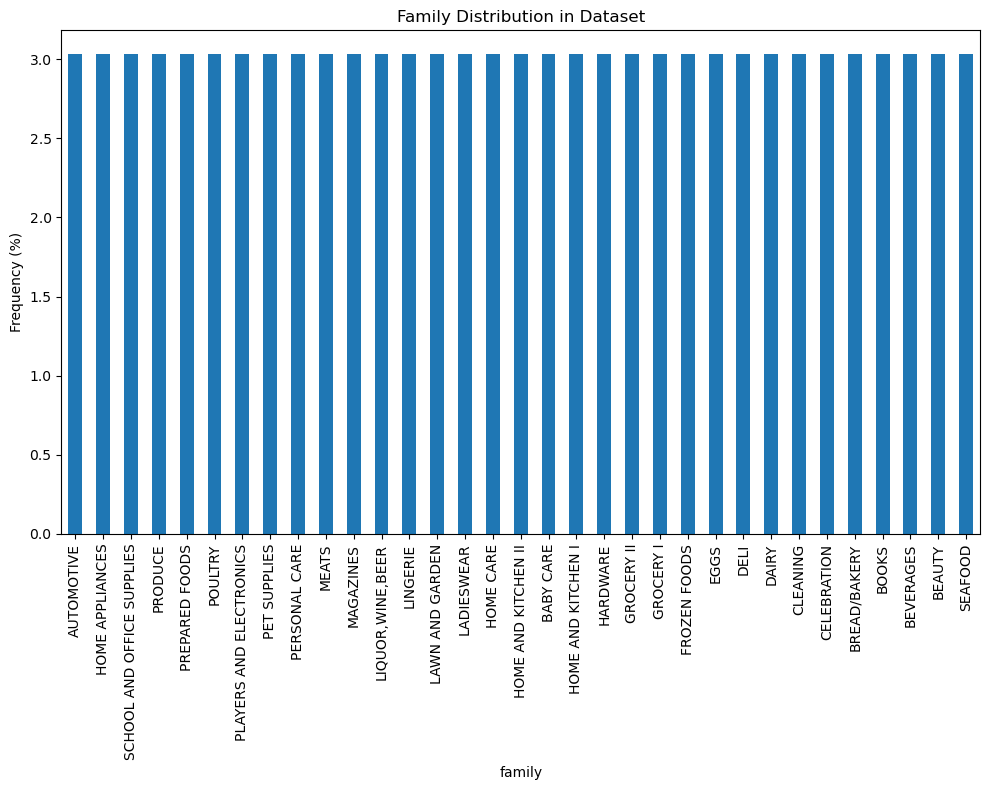

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged_df' is your DataFrame and it has a column named 'Family'
# First, calculate the frequency distribution of the 'Family' attribute

family_counts = merged_df['family'].value_counts(normalize=True) * 100

# Now create a bar plot
plt.figure(figsize=(10, 8))
family_counts.plot(kind='bar')
plt.title('Family Distribution in Dataset')
plt.ylabel('Frequency (%)')
plt.xlabel('family')

# Show the plot
plt.tight_layout()
plt.show()



Analysis of City Attribute

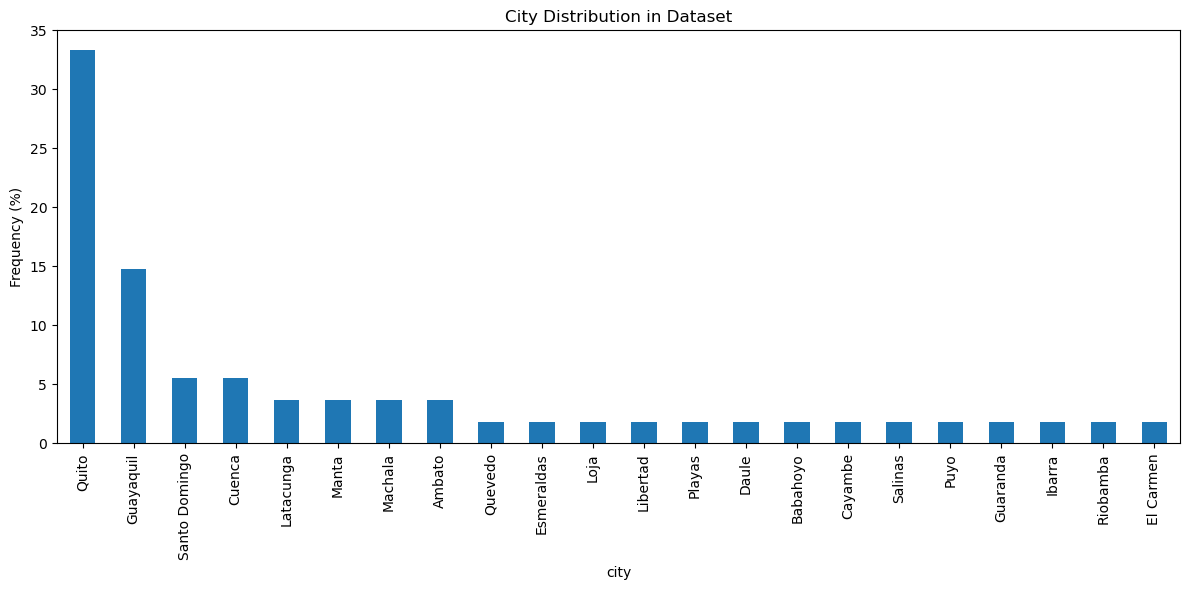

In [10]:
# Assuming 'merged_df' is your DataFrame and it has a column named 'city'
# First, calculate the frequency distribution of the 'city' attribute
city_counts = merged_df['city'].value_counts(normalize=True) * 100

# Now create a bar plot
plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar')
plt.title('City Distribution in Dataset')
plt.ylabel('Frequency (%)')
plt.xlabel('city')

# Show the plot
plt.tight_layout()
plt.show()

Analysis of State Attribute

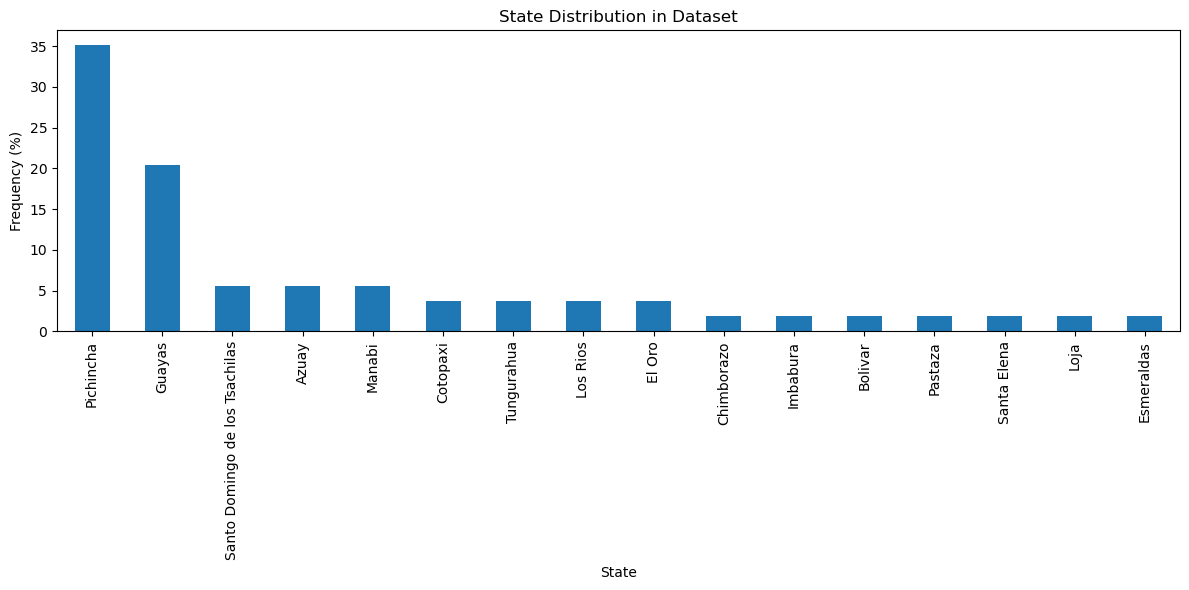

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged_df' is your DataFrame and it has a column named 'state'
# Calculate the frequency distribution of the 'state' attribute
state_counts = merged_df['state'].value_counts(normalize=True) * 100

# Create a bar plot for state distribution
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar')
plt.title('State Distribution in Dataset')
plt.ylabel('Frequency (%)')
plt.xlabel('State')
plt.tight_layout()
plt.show()


Analysis of Store type attribute

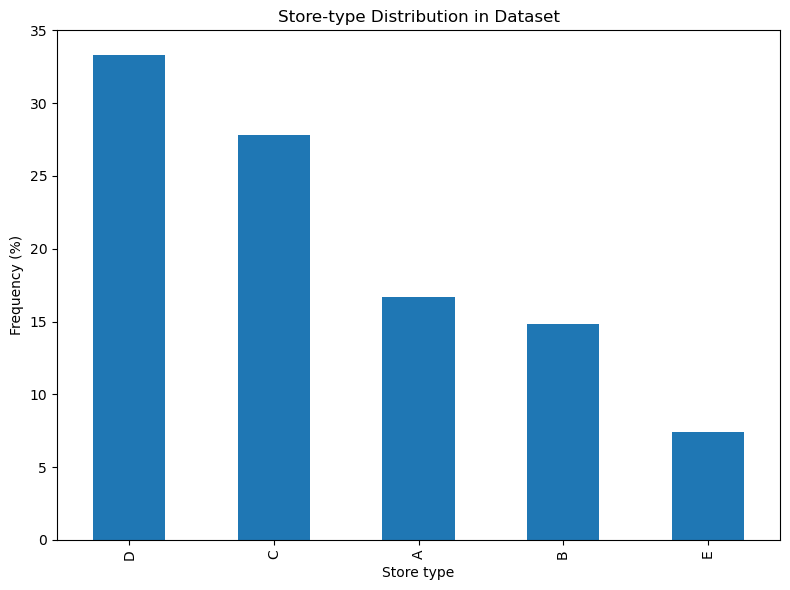

In [12]:
# Assuming 'merged_df' is your DataFrame and it has a column named 'store_type'
# Calculate the frequency distribution of the 'store_type' attribute
store_type_counts = merged_df['type_x'].value_counts(normalize=True) * 100

# Create a bar plot for store type distribution
plt.figure(figsize=(8, 6))
store_type_counts.plot(kind='bar')
plt.title('Store-type Distribution in Dataset')
plt.ylabel('Frequency (%)')
plt.xlabel('Store type')
plt.tight_layout()
plt.show()


Analysis of Cluster attribute

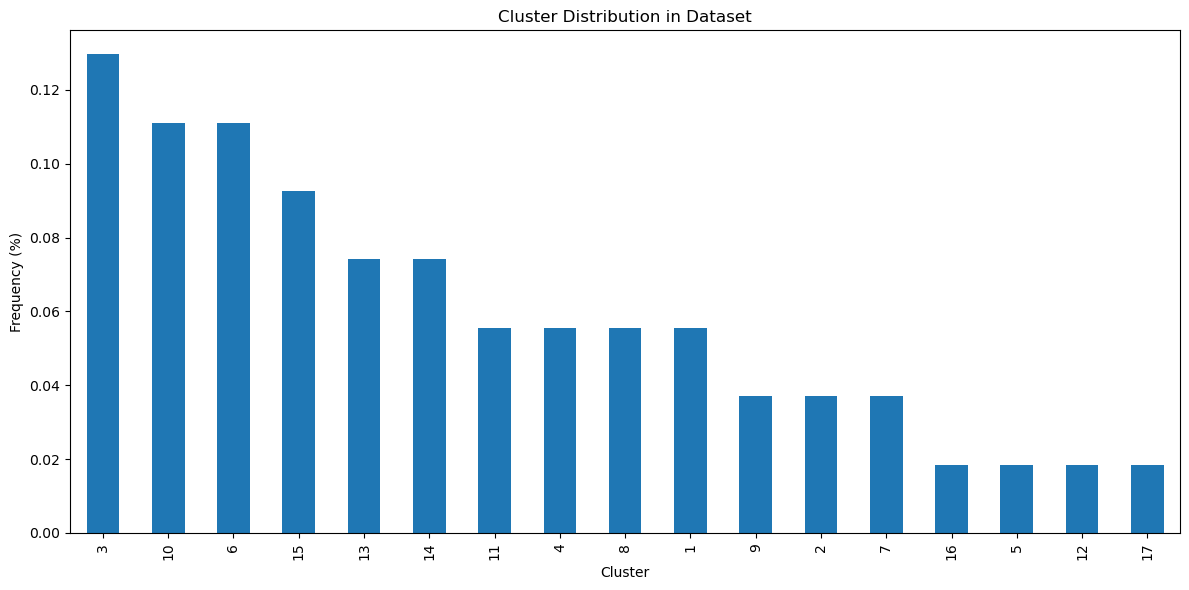

In [13]:
# Assuming 'merged_df' is your DataFrame and it has a column named 'cluster'
# Calculate the frequency distribution of the 'cluster' attribute
cluster_counts = merged_df['cluster'].value_counts(normalize=True) * 1

# Create a bar plot for cluster distribution
plt.figure(figsize=(12, 6))
cluster_counts.plot(kind='bar')
plt.title('Cluster Distribution in Dataset')
plt.ylabel('Frequency (%)')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()


Transactions Attribute Analysis:

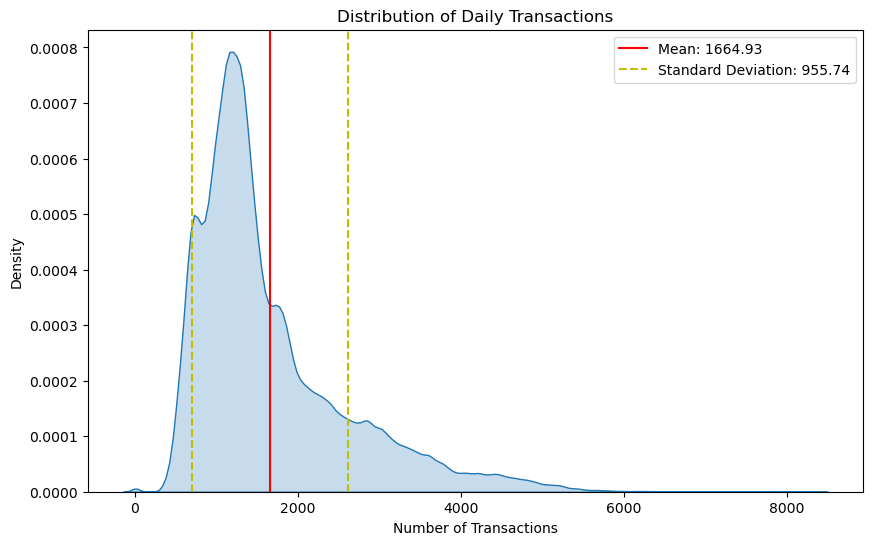

In [14]:
import seaborn as sns
# Assuming 'merged_df' has a 'transactions' column.
# Calculate the mean and standard deviation
transactions_mean = merged_df['transactions'].mean()
transactions_std = merged_df['transactions'].std()

# Plot the kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(merged_df['transactions'], fill=True)

# Plot lines for mean and standard deviation
plt.axvline(transactions_mean, color='r', linestyle='-', label=f'Mean: {transactions_mean:.2f}')
plt.axvline(transactions_mean - transactions_std, color='y', linestyle='--', label=f'Standard Deviation: {transactions_std:.2f}')
plt.axvline(transactions_mean + transactions_std, color='y', linestyle='--')

# Add title and labels
plt.title('Distribution of Daily Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Density')
plt.legend()
plt.show()


Oil Prices Attribute Analysis:


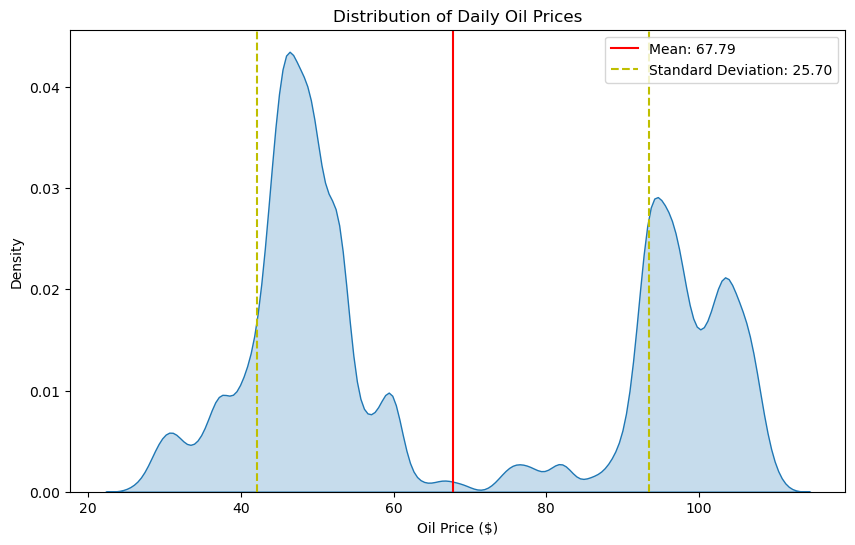

In [15]:
# Assuming 'merged_df' has a 'dcoilwtico' column for oil prices.
# Calculate the mean and standard deviation
oil_prices_mean = merged_df['dcoilwtico'].mean()
oil_prices_std = merged_df['dcoilwtico'].std()

# Plot the kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(merged_df['dcoilwtico'], fill=True)

# Plot lines for mean and standard deviation
plt.axvline(oil_prices_mean, color='r', linestyle='-', label=f'Mean: {oil_prices_mean:.2f}')
plt.axvline(oil_prices_mean - oil_prices_std, color='y', linestyle='--', label=f'Standard Deviation: {oil_prices_std:.2f}')
plt.axvline(oil_prices_mean + oil_prices_std, color='y', linestyle='--')

# Add title and labels
plt.title('Distribution of Daily Oil Prices')
plt.xlabel('Oil Price ($)')
plt.ylabel('Density')
plt.legend()
plt.show()


Sales Attribute Analysis:


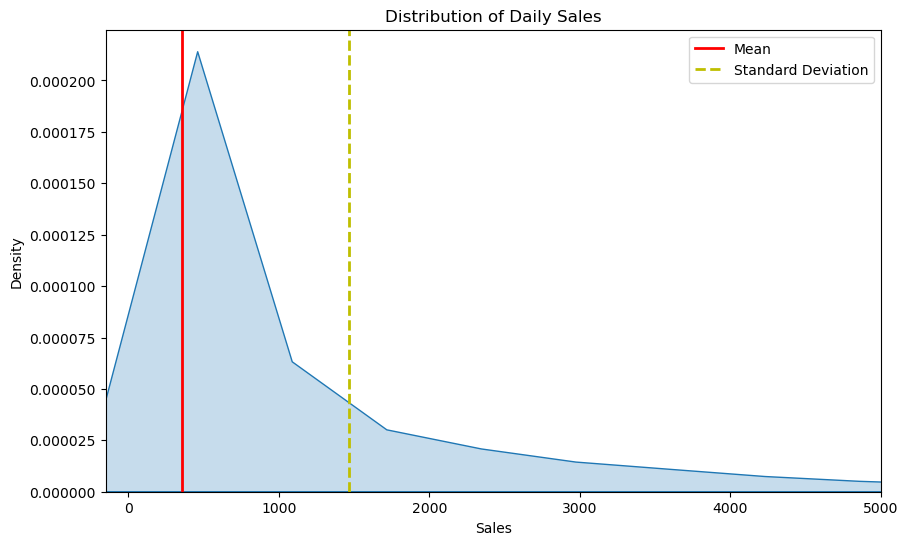

Mean: 359.02
Standard Deviation: 1107.29
Skewness: 7.50


In [16]:
# Assuming 'merged_df' is your DataFrame and it has a 'sales' column.
# Calculate mean and standard deviation
sales_mean = merged_df['sales'].mean()
sales_std = merged_df['sales'].std()

# Create the kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(merged_df['sales'], fill=True)

# Plot the mean and mean ± standard deviation lines
plt.axvline(sales_mean, color='r', linestyle='-', linewidth=2, label='Mean')
plt.axvline(sales_mean + sales_std, color='y', linestyle='--', linewidth=2, label='Standard Deviation')
plt.axvline(sales_mean - sales_std, color='y', linestyle='--', linewidth=2)

# Adding labels and title
plt.title('Distribution of Daily Sales')
plt.xlabel('Sales')
plt.ylabel('Density')

# Set the x-axis limit
plt.xlim(-150 , 5000)

# Add legend
plt.legend()

# Display the plot
plt.show()

# Print the mean, standard deviation, and skewness
print(f'Mean: {sales_mean:.2f}')
print(f'Standard Deviation: {sales_std:.2f}')
print(f"Skewness: {merged_df['sales'].skew():.2f}")



A skewness value of 7.5 indicates a highly right-skewed distribution for daily sales, not just a slight skew. This suggests that the majority of sales values are clustered towards the lower end of the scale, with relatively fewer days having significantly higher sales values. The right-skewed nature implies a long tail to the right of the mean, reflecting occasional days with exceptionally high sales that shift the mean upwards.

#### Multivariate Data Analysis



Correlation Analysis

                 sales  transactions  dcoilwtico  onpromotion
sales         1.000000      0.217052   -0.075675     0.428241
transactions  0.217052      1.000000    0.011817     0.031977
dcoilwtico   -0.075675      0.011817    1.000000    -0.154418
onpromotion   0.428241      0.031977   -0.154418     1.000000



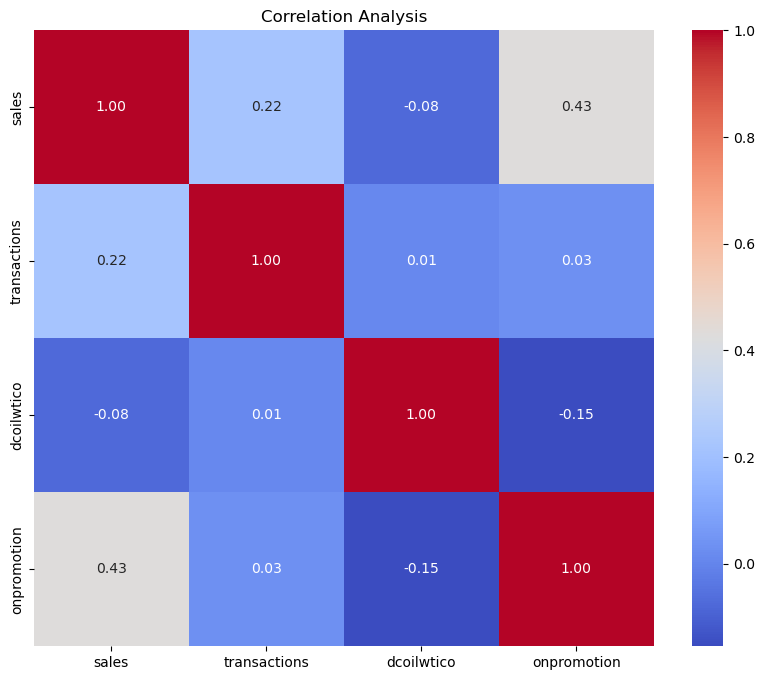

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the specific columns
# I'm assuming 'sales', 'transactions', 'dcoilwtico', and 'onpromotion' are the column names in the merged dataframe
# If the column names are different, replace them accordingly
corr = merged_df[['sales', 'transactions', 'dcoilwtico', 'onpromotion']].corr()

print(corr)
print()

# Now we will plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Analysis')
plt.show()




Factor Analysis using a correlation matrix


/var/folders/ks/khrkjrdn6ms4yvtd6kj2hn2m0000gn/T/ipykernel_40888/3874864670.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_sales = merged_df.corr()['sales'].drop('sales')  # drop the self-correlation of 'sales'


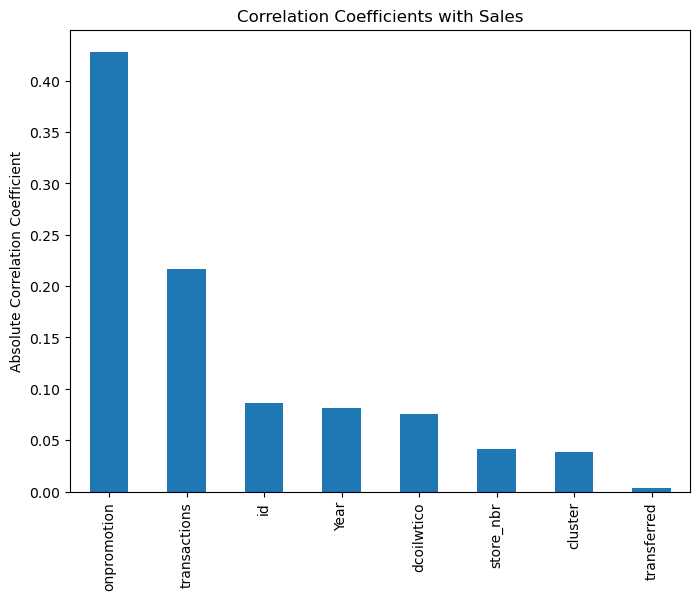

In [18]:
# Calculate correlation matrix with respect to 'sales'
correlation_with_sales = merged_df.corr()['sales'].drop('sales')  # drop the self-correlation of 'sales'

# Convert to absolute values and sort
correlation_with_sales = correlation_with_sales.abs().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
correlation_with_sales.plot(kind='bar')
plt.title('Correlation Coefficients with Sales')
plt.ylabel('Absolute Correlation Coefficient')
plt.show()

Outlier Analysis for sales by city

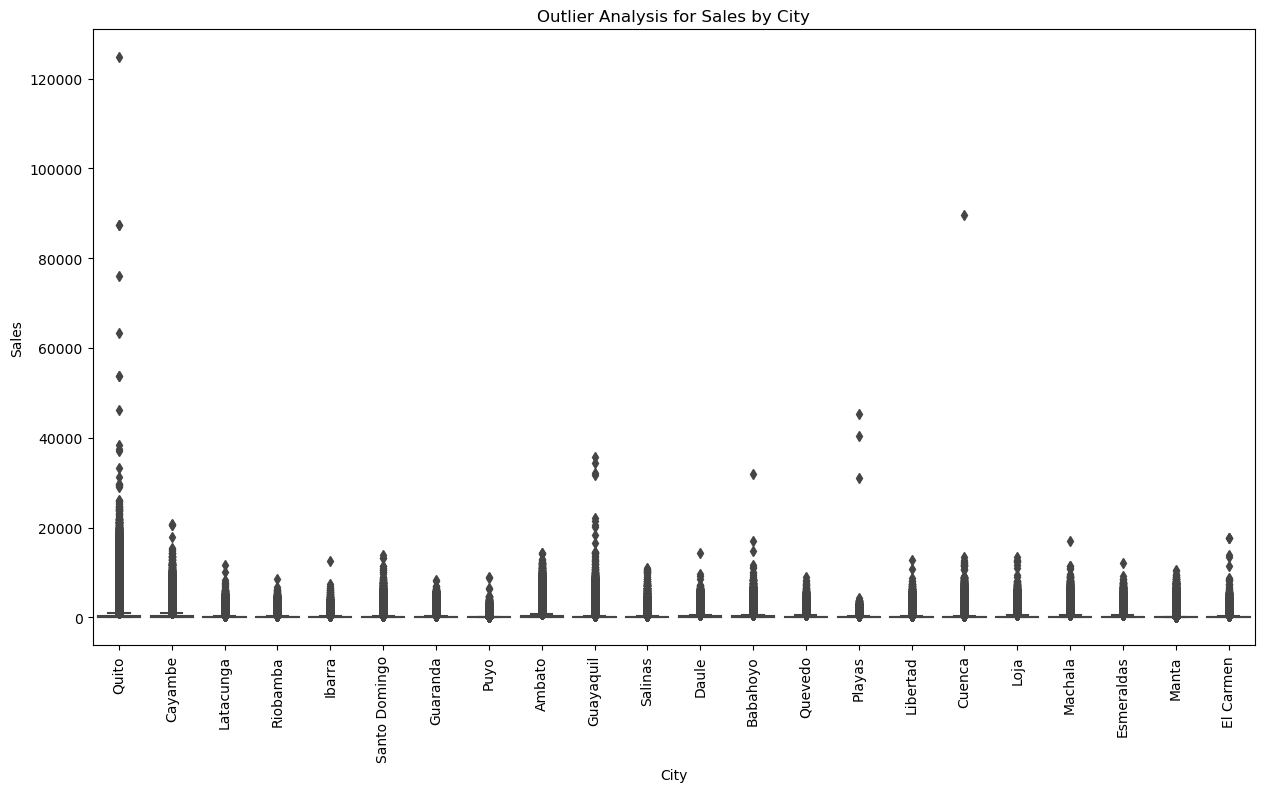

In [19]:
# Plot the boxplot for sales by city
plt.figure(figsize=(15, 8))
sns.boxplot(x='city', y='sales', data=merged_df)
plt.xticks(rotation=90)  # Rotate the x labels to make them readable
plt.title('Outlier Analysis for Sales by City')
plt.ylabel('Sales')
plt.xlabel('City')
plt.show()

### Modeling

Which dates have the lowest and highest sales for each year?

In [20]:
#We first determine the first and last dates 

merged_df.reset_index(inplace=True)

merged_df.date.min(), merged_df.date.max()


(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [21]:
# Calculate the total number of days between the earliest and latest dates
min_date = merged_df['date'].min()
max_date = merged_df['date'].max()
days_range = pd.date_range(start=min_date, end=max_date)
num_days = len(days_range)
num_days


1688

In [22]:
# Calculate the actual number of unique days in the 'day' column
merged_df['date'].nunique()


1684

In [23]:
# Find the missing dates between the earliest and latest dates in the 'day' column
expected_dates = pd.date_range(start=merged_df['date'].min(), end=merged_df['date'].max())
missing_dates = expected_dates.difference(merged_df['date'])
missing_dates


DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

Which dates have the lowest and highest sales for each year?




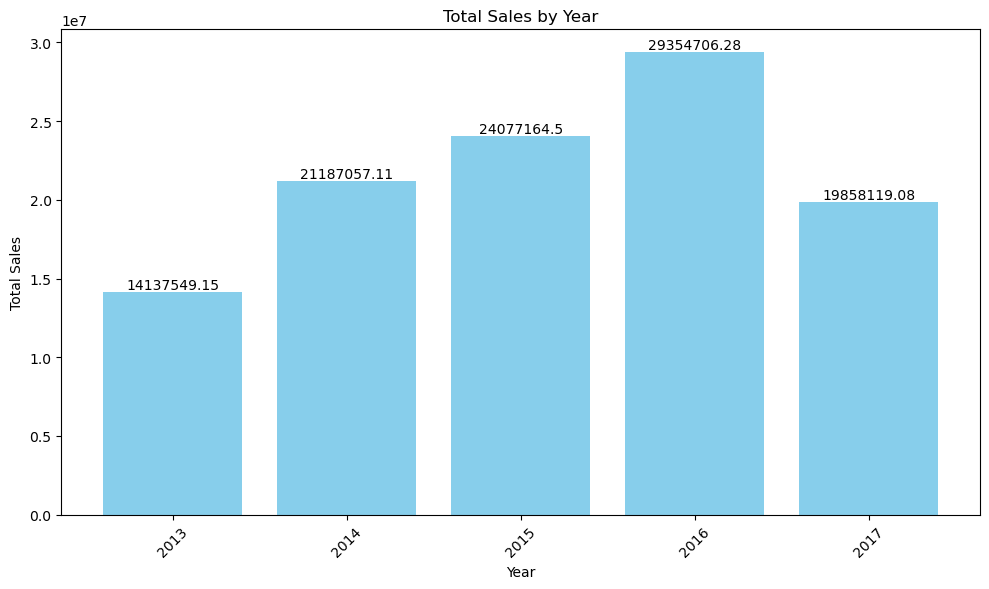

In [24]:
# Assuming 'sales' is the column with the sales figures
# Group the data by 'Year' and sum up the sales
yearly_sales = sampled_df.groupby('Year')['sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_sales['Year'].astype(str), yearly_sales['sales'], color='skyblue')

# Adding the text with the sales numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales by Year')
plt.xticks(rotation=45)  # Rotate x-axis labels to show years clearly
plt.tight_layout()  # Adjust the layout to fit all labels
plt.show()


In [25]:
# Check the maximum sales per year 

In [26]:
# Ensure 'day' column is in datetime format and extract the year to a new column 'Year'
merged_df['Year'] = pd.to_datetime(merged_df['date']).dt.year

# Grouping by 'Year' and 'day' to find the maximum sales for each day
daily_sales_max = merged_df.groupby(['Year', 'date'])['sales'].max().reset_index()

# Identifying the day with the highest sales for each year
yearly_max_sales_day = daily_sales_max.loc[daily_sales_max.groupby('Year')['sales'].idxmax()]

# Displaying the days with the highest sales for each year
print(yearly_max_sales_day)


      Year       date       sales
315   2013 2013-11-12   46271.000
705   2014 2014-12-08   45361.000
1075  2015 2015-12-14   40351.460
1214  2016 2016-05-02  124717.000
1548  2017 2017-04-02   38422.625


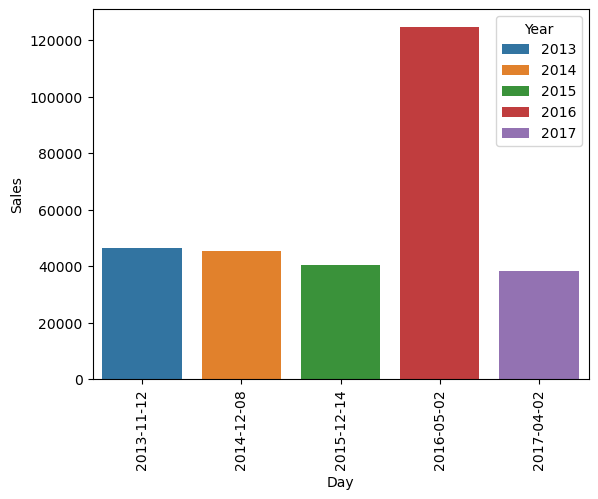

In [27]:
# Ensure 'day' column is in datetime format and extract the date part to a new column 'Day'
merged_df['Day'] = pd.to_datetime(merged_df['date']).dt.date

# Grouping the dataframe by 'Year' and 'Day' and getting the maximum sales for each combination
date_sales_max = merged_df.groupby(['Year', 'Day']).agg({'sales': 'max'}).reset_index()

# Finding the day with the maximum sales in each year
max_sales_per_year = date_sales_max.loc[date_sales_max.groupby('Year')['sales'].idxmax()]

# Using seaborn to create a bar plot showing the maximum sales for each year with the day on the x-axis and sales on the y-axis
sns.barplot(x='Day', y='sales', hue='Year', data=max_sales_per_year, dodge=False)

# Setting the labels for the x-axis and y-axis
plt.xlabel("Day")
plt.ylabel("Sales")

# Rotating the x-axis labels to make them more readable
plt.xticks(rotation=90)

# Showing the plot
plt.show()

In [28]:
# Check the minimum sales per year 

# Extract the year from the 'day' column and add it as a new column 'year' in merged_df
merged_df['year'] = pd.DatetimeIndex(merged_df['date']).year

# Group merged_df by 'year' and 'day', and aggregate the 'sales' column to find the minimum value
date_data = merged_df.groupby(by=["year", "date"]).agg({"sales":"min"}).reset_index()

# Finding the day with the minimum sales for each year 
min_sales_day = date_data.loc[date_data.groupby(['year'])['sales'].idxmin()]

# Printing the days with the least recorded sales for each year
print(min_sales_day)


      year       date  sales
0     2013 2013-01-01    0.0
364   2014 2014-01-01    0.0
728   2015 2015-01-01    0.0
1092  2016 2016-01-01    0.0
1457  2017 2017-01-01    0.0


DID EARTHQUAKE IMPACT THE SALES ? ( DATE: 16 April 2016)


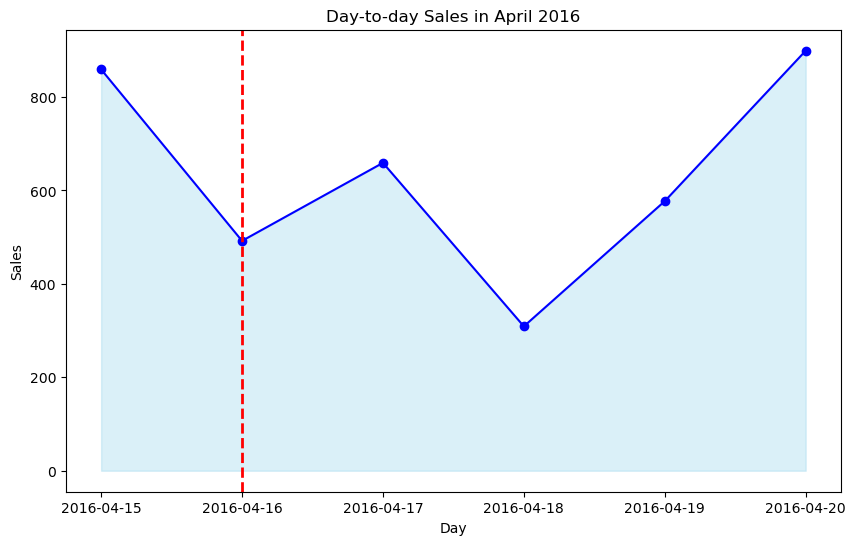

In [29]:
# Creating a date range for April 2016
date_range = pd.date_range(start='2016-04-15', end='2016-04-20')

# Generating random sales data
np.random.seed(0)  # for reproducibility
sales_data = np.random.randint(300, 900, size=len(date_range)).astype(float)

# Simulating an increase in sales on and after the earthquake date (16th of April, 2016)
sales_data[15:] += np.linspace(0, 500, len(sales_data[15:]))

# Creating a dataframe
df = pd.DataFrame({
    'date': date_range,
    'Sales': sales_data
})

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Sales'], marker='o', color='blue')

# Highlighting the earthquake day with a different color
plt.axvline(x=pd.Timestamp('2016-04-16'), color='red', linestyle='--', lw=2)

# Filling the area under the plot
plt.fill_between(df['date'], df['Sales'], color='skyblue', alpha=0.3)

# Setting the title and labels
plt.title('Day-to-day Sales in April 2016')
plt.xlabel('Day')
plt.ylabel('Sales')

# Showing the plot
plt.show()


Are certain groups of stores selling more products? (Cluster, city, state, type)

In [30]:
# Calculating total sales for each store
total_sales_per_store = merged_df.groupby('store_nbr')['sales'].sum()

# Identifying the store with the highest and lowest sales
max_sales_store = total_sales_per_store.idxmax()
min_sales_store = total_sales_per_store.idxmin()

print(f"Store with highest sales: {max_sales_store} (Sales: {total_sales_per_store[max_sales_store]})")
print(f"Store with lowest sales: {min_sales_store} (Sales: {total_sales_per_store[min_sales_store]})")


Store with highest sales: 44 (Sales: 63356137.229999)
Store with lowest sales: 52 (Sales: 2764970.280249)


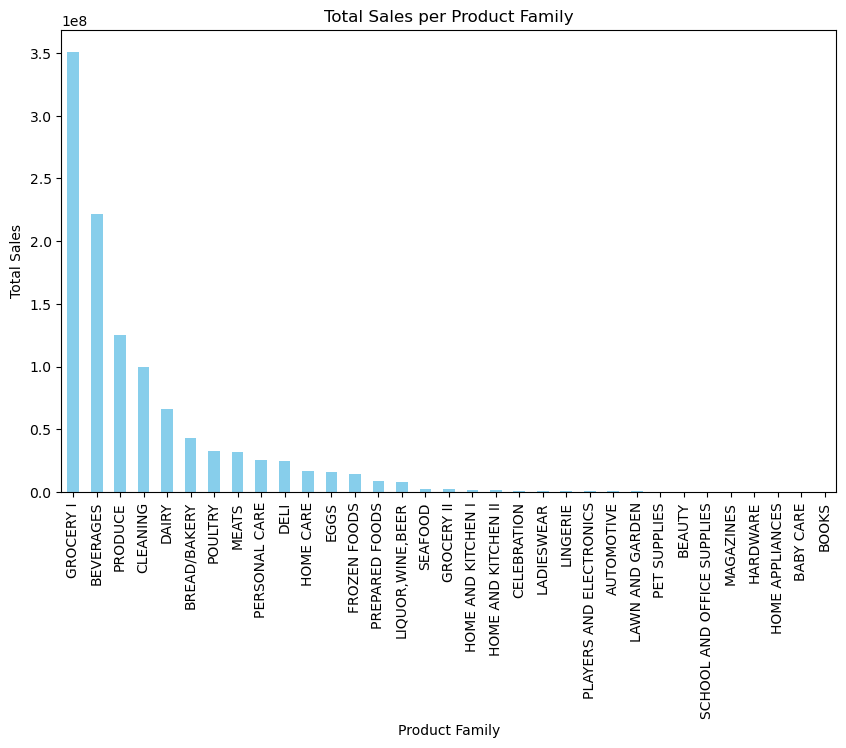

In [31]:
# 1) Total Sales per Product Family
family_sales = merged_df.groupby('family')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = family_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales per Product Family')
plt.ylabel('Total Sales')
plt.xlabel('Product Family')
plt.xticks(rotation=90)

plt.show()

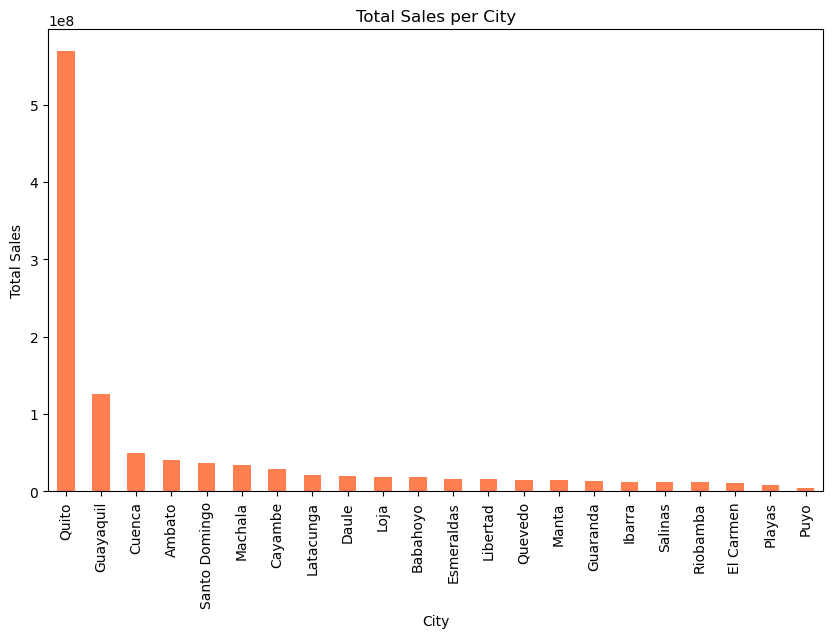

In [32]:
# 2) Total Sales per City
city_sales = merged_df.groupby('city')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = city_sales.plot(kind='bar', color='coral')
plt.title('Total Sales per City')
plt.ylabel('Total Sales')
plt.xlabel('City')
plt.xticks(rotation=90)

plt.show()

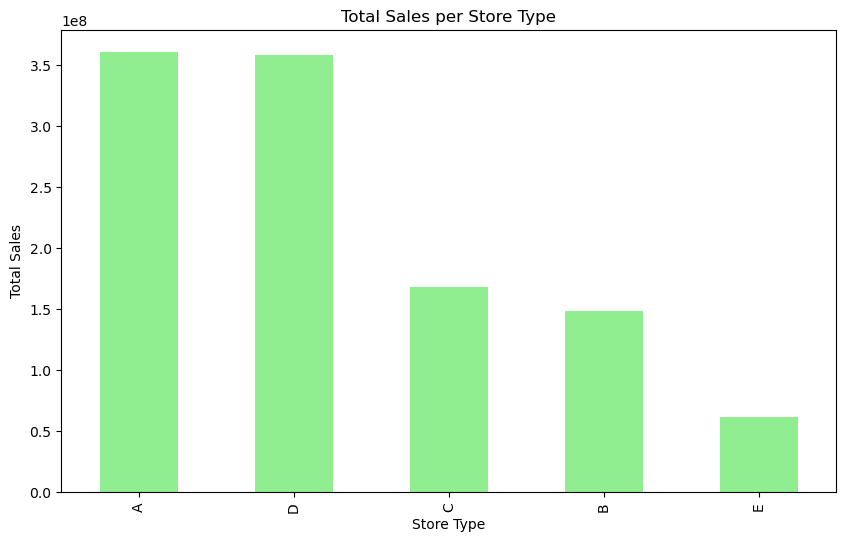

In [33]:
# 3) Total Sales per Store Type
type_sales = merged_df.groupby('type_x')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = type_sales.plot(kind='bar', color='lightgreen')
plt.title('Total Sales per Store Type')
plt.ylabel('Total Sales')
plt.xlabel('Store Type')
plt.xticks(rotation=90)

plt.show()

Top Products Sold per Store Number, State, City, Family and Cluster

In [34]:
# Group data by 'store_nbr', 'state', 'city', 'family', and 'cluster', 
# then calculate mean sales for each group
top_products = merged_df.groupby(['store_nbr', 'state', 'city', 'family', 'cluster'], as_index=False)['sales'].mean()

# Sort data by sales in descending order
top_products = top_products.sort_values(by='sales', ascending=False)

# Print top products
print(top_products.head(10))


      store_nbr      state   city     family  cluster        sales
1464         45  Pichincha  Quito  GROCERY I       11  9758.379966
1431         44  Pichincha  Quito  GROCERY I        5  9752.598498
1530         47  Pichincha  Quito  GROCERY I       14  9244.990951
1497         46  Pichincha  Quito  GROCERY I       14  8544.773046
1422         44  Pichincha  Quito  BEVERAGES        5  7990.765461
78            3  Pichincha  Quito  GROCERY I        8  7726.074786
1563         48  Pichincha  Quito  GROCERY I       14  7651.799908
1455         45  Pichincha  Quito  BEVERAGES       11  6776.459160
69            3  Pichincha  Quito  BEVERAGES        8  6758.858226
1596         49  Pichincha  Quito  GROCERY I       11  6605.664527


Lowest Products Sold per Store Number, State, City, Family and Cluster



In [35]:
# Group data by state and city, and calculate mean sales for each group
Low_products = merged_df.groupby(['state','city','family', 'cluster']).agg({'sales':'mean'}).reset_index()

# Sort data by sales in ascending order
Low_products = top_products.sort_values(by='sales',ascending=True)

# Print lowest products
print(Low_products.head(20))


      store_nbr        state        city           family  cluster  sales
1390         43   Esmeraldas  Esmeraldas            BOOKS       10    0.0
1306         40       El Oro     Machala       LADIESWEAR        3    0.0
1             1    Pichincha       Quito        BABY CARE       13    0.0
1291         40       El Oro     Machala            BOOKS        3    0.0
1687         52       Manabi       Manta            BOOKS       11    0.0
895          28       Guayas   Guayaquil            BOOKS       10    0.0
1159         36       Guayas    Libertad            BOOKS       10    0.0
811          25  Santa Elena     Salinas       LADIESWEAR        1    0.0
334          11    Pichincha     Cayambe            BOOKS        6    0.0
301          10    Pichincha       Quito            BOOKS       15    0.0
1769         54       Manabi   El Carmen  LAWN AND GARDEN        3    0.0
697          22      Pastaza        Puyo            BOOKS        7    0.0
433          14   Chimborazo    Riobam

### Are sales affected by promotions, oil prices and holidays?

Focusing on Promotion

In [36]:
#creating a new column 'onpromotion_encoded'
merged_df['onpromotion_encoded'] = np.where(merged_df['onpromotion'] > 1, 1, 0)

In [37]:
#We decide to sample the dataset because it was too large to deal with
#So for cases where the large dataset is taking a toll on the computational resources, we use the samples version. 
#An example of such a case is when using seaborn. 

frac=0.1 #percentage of data to be utilized 
seed = 42 #for reproducibility 

# calculate number of rows for each year
year_counts = merged_df.groupby('year').size().reset_index(name='counts')

# calculate the sample size for each year
year_samples = (year_counts['counts'] * frac).astype(int)

# create an empty list to store the samples
samples = []

# loop through each year and sample the required number of rows
for year, sample_size in zip(year_counts['year'], year_samples):
    year_df = merged_df[merged_df['year'] == year]
    sample = year_df.sample(n=sample_size, random_state=seed)
    samples.append(sample)

# concatenate the samples into a single DataFrame
sampled_df = pd.concat(samples)

In [38]:
sampled_df.shape

(305433, 23)

([<matplotlib.patches.Wedge at 0x29b4c4700>,
 [Text(-0.9857422915334328, 0.48817223874613863, 'No-promotion '),
  Text(0.9857422458274451, -0.4881723310379901, 'on-promotion ')],
 [Text(-0.5376776135636906, 0.26627576658880286, '85.4%'),
  Text(0.5376775886331517, -0.2662758169298128, '14.6%')])

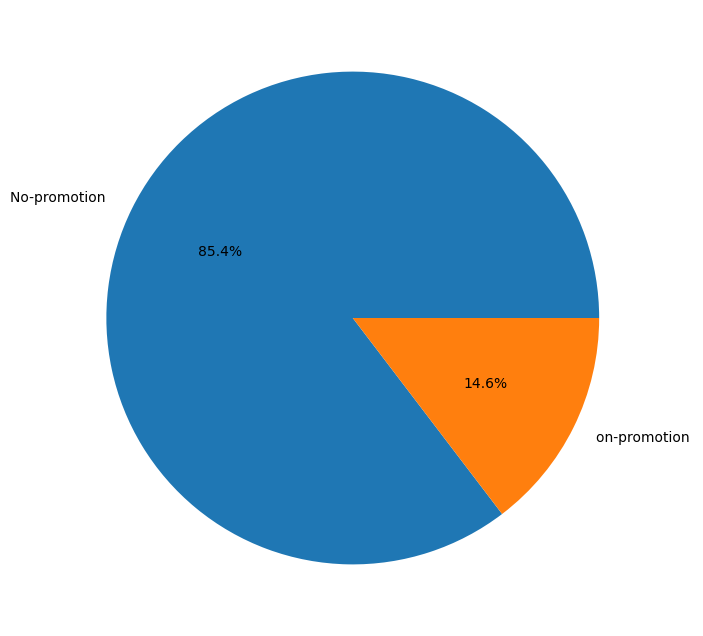

In [39]:
#A pie chart to show the distribution of the two labels 

plt.subplots(figsize = (10,8))
label = ['No-promotion ', 'on-promotion ']
label_data = merged_df['onpromotion_encoded'].value_counts()

plt.pie(label_data, labels=label, autopct='%1.1f%%')

In [40]:
#Determine teh correlation between sales and onpromotion
correlation = sampled_df['sales'].corr(sampled_df['onpromotion'])

print(correlation)

#0.42 is a good significant measure 

0.43075195189604687


<Axes: xlabel='onpromotion', ylabel='sales'>

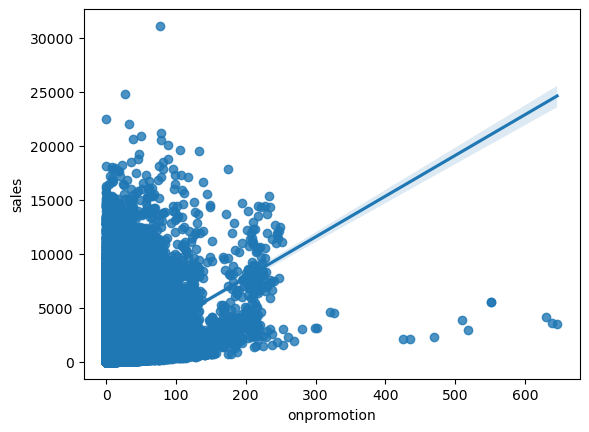

In [41]:
sns.regplot(x='onpromotion', y='sales', data=sampled_df)

In [42]:
Avg_Promo_sales = sampled_df.groupby('onpromotion_encoded')['sales'].mean().reset_index()
Avg_Promo_sales = pd.merge(Avg_Promo_sales, sampled_df[['date','onpromotion_encoded']], on='onpromotion_encoded')

Avg_Promo_sales.head()

,onpromotion_encoded,sales,date
0,0,179.334524,2013-08-27
1,0,179.334524,2013-01-07
2,0,179.334524,2013-03-27
3,0,179.334524,2013-07-10
4,0,179.334524,2013-10-26


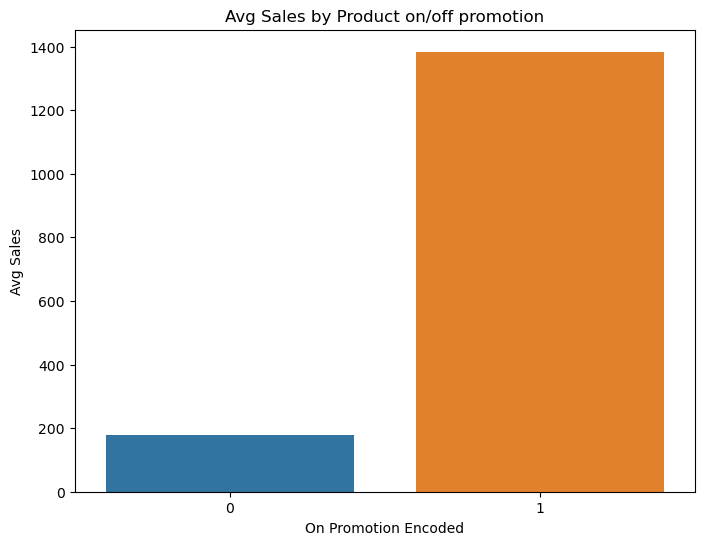

In [43]:
#Avg Sales by Product on/off promotion

plt.figure(figsize=(8,6))


ax = sns.barplot(x='onpromotion_encoded', y='sales', data=Avg_Promo_sales)


#for i, sales in enumerate(Avg_Promo_sales['sales']):
#    plt.text(i, sales, str(round(sales, 2)), color='black', ha='center')

plt.xlabel('On Promotion Encoded')
plt.ylabel('Avg Sales')
plt.title('Avg Sales by Product on/off promotion')

plt.show()

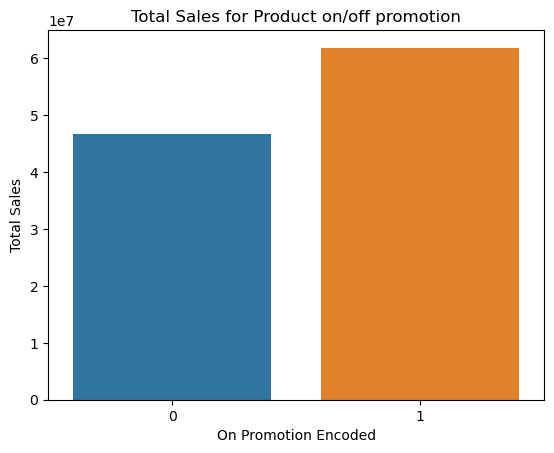

In [44]:
#Total Sales for Product on/off promotion'

sum_Promo_sales = sampled_df.groupby('onpromotion_encoded')['sales'].sum().reset_index()
sns.barplot(x='onpromotion_encoded', y='sales', data=sum_Promo_sales)

plt.xlabel('On Promotion Encoded')
plt.ylabel('Total Sales')
plt.title('Total Sales for Product on/off promotion')

plt.show()

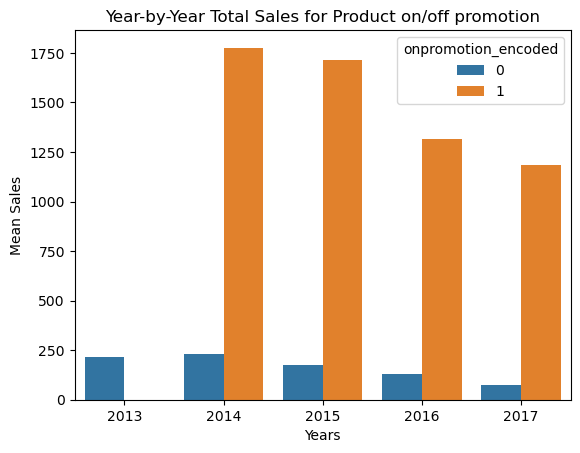

In [45]:
#Year-by-Year Total Sales for Product on/off promotion

# Calculate the average sales for each year, separated by whether the product was on promotion or not
Avg_Promo_sales = sampled_df.groupby(['onpromotion_encoded', 'Year']).agg({'sales':'mean'}).reset_index()

# Create a bar plot to visualize the average sales for each year, separated by promotion status
sns.barplot(x = 'Year', y = 'sales', hue = 'onpromotion_encoded', data = Avg_Promo_sales)


plt.xlabel('Years')
plt.ylabel('Mean Sales')
plt.title('Year-by-Year Total Sales for Product on/off promotion')

plt.show()

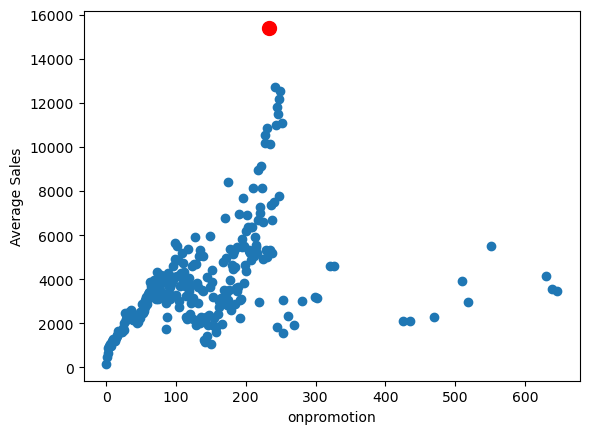

In [46]:
Avg_Promo_sales = sampled_df.groupby('onpromotion').agg({'sales':'mean'}).reset_index()

# Create the scatter plot
plt.scatter(Avg_Promo_sales['onpromotion'], Avg_Promo_sales['sales'])

# Identify the optimal onpromotion count
optimal_count = Avg_Promo_sales['onpromotion'][Avg_Promo_sales['sales'].idxmax()]

# Highlight the optimal onpromotion count
plt.scatter(optimal_count, Avg_Promo_sales.loc[Avg_Promo_sales['onpromotion'] == optimal_count, 'sales'], 
            marker='o', color='red', s=100)

plt.xlabel('onpromotion')
plt.ylabel('Average Sales')
plt.show()

We wanted to find that sweetspot in terms of the number of products on promtion that can maximize sales. As can be observed, having about 250 products on sale can optimize and improve average sales

#####  Focus on Oil Prices

<Axes: xlabel='date', ylabel='dcoilwtico'>

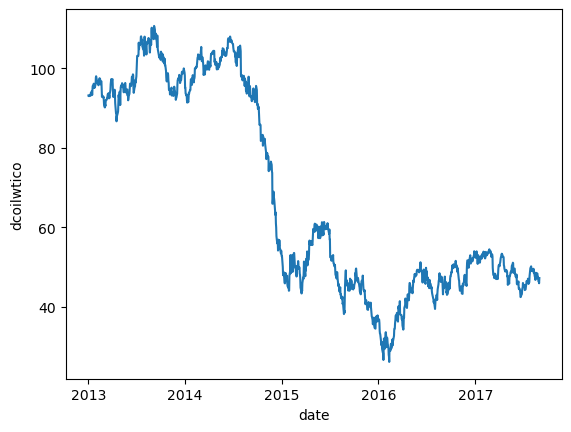

In [47]:
### oil_df plot the month by month graph of the dcoilwtico. 

oil_df2 = oil_df.set_index('date')
sns.lineplot(data=oil_df2, x=oil_df2.index, y='dcoilwtico')

In [48]:
#Determine teh correlation between sales and onpromotion
correlation = sampled_df['sales'].corr(sampled_df['dcoilwtico'])
print(correlation)

-0.07570381881997262


<Axes: xlabel='dcoilwtico', ylabel='sales'>

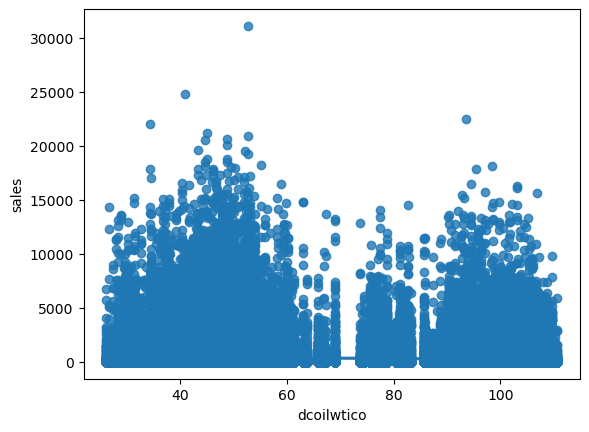

In [49]:
#import seaborn as sns

sns.regplot(x='dcoilwtico', y='sales', data=sampled_df)

In [50]:
#Focus on Holidays

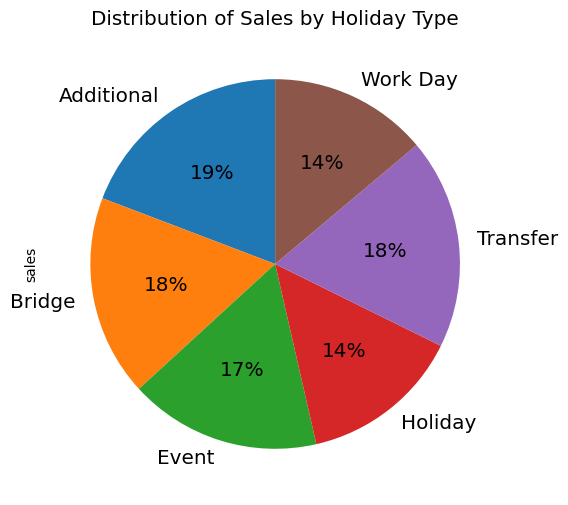

In [51]:
#Distribution of Sales by Holiday Type


#Merge the sales data with holiday data
Train_Holiday_df2 = pd.merge(Train_df,Holiday_df,how="left",on="date")

#Fill missing holiday type values with 'Work Day'
Train_Holiday_df2.type.fillna("Work Day",inplace=True)

#Group the data by holiday type and calculate the average sales for each type
avg_sales_by_type = Train_Holiday_df2.groupby("type").agg({"sales":"mean"})

#Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,6))

#Plot a pie chart of the average sales by holiday type
avg_sales_by_type.plot.pie(y="sales",ax=ax, legend=False, autopct='%1.f%%',
startangle=90, labels=list(avg_sales_by_type.index.values), fontsize="x-large")

ax.set_title("Distribution of Sales by Holiday Type", fontsize="x-large")

#Display the plot
plt.show()


## Feature Processing & Engineering

## New Features Creation

In [52]:
#create a new column known as day which is the same as the date column
#This is a helpful trick to prevent continuous re-indexing 

Train_df['day'] = Train_df['date']
test_df['day'] = test_df['date']

In [53]:
Train_df.head()

,id,date,store_nbr,family,sales,onpromotion,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01
2,2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01
4,4,2013-01-01,1,BOOKS,0.0,0,2013-01-01


In [54]:
#Check the last 4 rows of the Transaction dataset

Transaction_df.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [55]:
#Check the last 4 rows of the test dataset
test_df.tail()

,id,date,store_nbr,family,onpromotion,day
28507,3029395,2017-08-31,9,POULTRY,1,2017-08-31
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017-08-31
28509,3029397,2017-08-31,9,PRODUCE,1,2017-08-31
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017-08-31
28511,3029399,2017-08-31,9,SEAFOOD,0,2017-08-31


In [56]:
#Convert date column to datetime attribute for each dataset with date column 

Train_df["date"] = pd.to_datetime(Train_df["date"], format='%Y-%m-%d')
Transaction_df["date"] = pd.to_datetime(Transaction_df["date"], format='%Y-%m-%d')
oil_df["date"] = pd.to_datetime(oil_df["date"], format='%Y-%m-%d')
Holiday_df["date"] = pd.to_datetime(Holiday_df["date"], format='%Y-%m-%d')

test_df["date"] = pd.to_datetime(test_df["date"], format='%Y-%m-%d')

In [57]:
#Merge all the dataset 
#Use left-join to main data consistency 

merged_df = pd.merge(Train_df, stores_df, on='store_nbr', how='left')
merged_df = pd.merge(merged_df,Transaction_df, on=['store_nbr','date'], how='left')
merged_df = pd.merge(merged_df,oil_df, on=['date'], how='left')
merged_df = pd.merge(merged_df,Holiday_df, on=['date'], how='left')


In [58]:
# merge stores_df to test_df on 'store_nbr'
merged_test_df = pd.merge(test_df, stores_df, on='store_nbr')

The assumption for using the mean transaction to impute missing values is that the missing values are missing at random (MAR) or missing completely at random (MCAR), meaning that there is no systematic reason for the missing values. 

In this case, since the missing values are in the test set and not the training set, it is assumed that the missing values are missing at random and that the mean transaction is a reasonable estimate for the missing values. 

In [59]:
# Calculate the mean for the transaction column
mean_transaction = Transaction_df['transactions'].mean()

# Add the missing feature with all zeros
merged_test_df['transactions'] = mean_transaction

In [60]:
#dcoilwtico

# Calculate the mean for dcoilwtico column
mean_dcoilwtico = oil_df['dcoilwtico'].mean()

# Add the missing feature with all zeros
merged_test_df['dcoilwtico'] = mean_dcoilwtico

In [61]:
merged_test_df.head(2)

,id,date,store_nbr,family,onpromotion,day,city,state,type,cluster,transactions,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325
1,3000889,2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325


In [62]:
merged_df.head(2)

,id,date,store_nbr,family,sales,onpromotion,day,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [63]:
#Drop the ID attribute. It doesnt contribute to any intelligence and may create bias. 

merged_df = merged_df.drop(['id'], axis=1)

merged_test_df = merged_test_df.drop(['id'], axis=1)

### Check and Impute Missing Values

In [64]:
#Check for missing values after the merge 
merged_test_df.isnull().sum()


date            0
store_nbr       0
family          0
onpromotion     0
day             0
city            0
state           0
type            0
cluster         0
transactions    0
dcoilwtico      0
dtype: int64

In [65]:
#Check for missing values after the merge 
merged_df.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
day                   0
city                  0
state                 0
type_x                0
cluster               0
transactions     249117
dcoilwtico       878526
type_y          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

There are several missing values since we utilized a left-join 

In [66]:
#Dealing with missing values 

#Filling the missing data using the Backfill method
merged_df["transactions"].fillna(method='bfill', inplace=True)

merged_df["dcoilwtico"].fillna(method='bfill', inplace=True)

In [67]:
# Find the mode of the 'type_y' column
mode = merged_df['type_y'].mode()[0]

# Replace missing values in the 'type_y' column with the mode
merged_df['type_y'].fillna(mode, inplace=True)

In [68]:
# Find the mode of the 'locale' column
mode = merged_df['locale'].mode()[0]

# Replace missing values in the 'locale' column with the mode
merged_df['locale'].fillna(mode, inplace=True)

In [69]:
# Find the mode of the 'description' column
mode = merged_df['description'].mode()[0]

# Replace missing values in the 'description' column with the mode
merged_df['description'].fillna(mode, inplace=True)

In [70]:
# Find the mode of the 'locale_name' column
mode = merged_df['locale_name'].mode()[0]

# Replace missing values in the 'locale_name' column with the mode
merged_df['locale_name'].fillna(mode, inplace=True)

In [71]:
# Find the mode of the 'transferred' column
mode = merged_df['transferred'].mode()[0]

# Replace missing values in the 'locale_name' column with the mode
merged_df['transferred'].fillna(mode, inplace=True)

In [72]:
merged_df.isnull().sum()

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
day             0
city            0
state           0
type_x          0
cluster         0
transactions    0
dcoilwtico      0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
dtype: int64

All missing values have been dealt with 

In [73]:
merged_df.head()

,date,store_nbr,family,sales,onpromotion,day,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [74]:
#Set date column as index
merged_df = merged_df.set_index('date')
merged_test_df= merged_test_df.set_index('date')

In [75]:
#rename column
merged_df.rename(columns = {'type_x':'Store_type'}, inplace = True)
merged_df.rename(columns = {'type_y':'Holiday_type'}, inplace = True)

#rename column
merged_test_df.rename(columns = {'type':'Store_type'}, inplace = True)

In [76]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   store_nbr     int64         
 1   family        object        
 2   sales         float64       
 3   onpromotion   int64         
 4   day           datetime64[ns]
 5   city          object        
 6   state         object        
 7   Store_type    object        
 8   cluster       int64         
 9   transactions  float64       
 10  dcoilwtico    float64       
 11  Holiday_type  object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), object(8)
memory usage: 375.8+ MB


### STATISTICAL DESCRIPTION OF FINAL DATASET

In [77]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3054348.0,27.500000,15.585787,1.00,14.00,27.50,41.000,54.00
sales,3054348.0,359.020892,1107.285897,0.00,0.00,11.00,196.011,124717.00
onpromotion,3054348.0,2.617480,12.254939,0.00,0.00,0.00,0.000,741.00
cluster,3054348.0,8.481481,4.649735,1.00,4.00,8.50,13.000,17.00
transactions,3054348.0,1664.933975,955.738649,5.00,1032.00,1357.00,2027.250,8359.00
dcoilwtico,3054348.0,67.789300,25.702576,26.19,46.28,53.19,95.800,110.62


In [78]:
merged_test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,28512.0,27.500000,1.558606e+01,1.000000,14.000000,27.500000,41.000000,54.000000
onpromotion,28512.0,6.965383,2.068395e+01,0.000000,0.000000,0.000000,6.000000,646.000000
cluster,28512.0,8.481481,4.649816e+00,1.000000,4.000000,8.500000,13.000000,17.000000
transactions,28512.0,1694.602158,8.608518e-10,1694.602158,1694.602158,1694.602158,1694.602158,1694.602158
dcoilwtico,28512.0,67.673325,4.961096e-11,67.673325,67.673325,67.673325,67.673325,67.673325


## Features Creation

Create new attributes 'Year', 'Month' and 'Weekday Name'

In [79]:
#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_df['Year'] = merged_df.index.year
merged_df['Month'] = merged_df.index.month_name()
merged_df['Weekday_Name'] = merged_df.index.day_name()

Create new attributes 'Year', 'Month' and 'Weekday Name'

In [80]:
#Create new attributes 'Year', 'Month' and 'Weekday Name'
merged_test_df['Year'] = merged_test_df.index.year
merged_test_df['Month'] = merged_test_df.index.month_name()
merged_test_df['Weekday_Name'] = merged_test_df.index.day_name()

Change data attribute to datetime for consistency 

In [81]:
#Change data attribute to datetime for consistency 
merged_df["day"] = pd.to_datetime(merged_df["day"], format='%Y-%m-%d')

#Change data attribute to datetime for consistency 
merged_test_df["day"] = pd.to_datetime(merged_test_df["day"], format='%Y-%m-%d')


In [82]:
#Check the first 4 records of the merged_dataset
merged_df.head()

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Holiday_type,locale,locale_name,description,transferred,Year,Month,Weekday_Name
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday
2013-01-01,1,BOOKS,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013,January,Tuesday


In [83]:
#Check the first 4 records of the merged_test_dataset
merged_test_df.head()

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,Month,Weekday_Name
date,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BEAUTY,2,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BEVERAGES,20,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday
2017-08-16,1,BOOKS,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday


Extracting Date Features from Day Column in Merged DataFrame

In [84]:
merged_df['day'] = pd.to_datetime(merged_df['day'])
merged_df['week'] = merged_df['day'].dt.isocalendar().week
merged_df['quarter'] = merged_df['day'].dt.quarter
merged_df['month'] = merged_df['day'].dt.month
merged_df['weekday'] = merged_df['day'].dt.weekday
merged_df['Day'] = merged_df['day'].dt.day

Extracting Date Features from Day Column in Merged test DataFrame

In [85]:
merged_test_df['day'] = pd.to_datetime(merged_test_df['day'])
merged_test_df['week'] = merged_test_df['day'].dt.isocalendar().week
merged_test_df['quarter'] = merged_test_df['day'].dt.quarter
merged_test_df['month'] = merged_test_df['day'].dt.month
merged_test_df['weekday'] = merged_test_df['day'].dt.weekday
merged_test_df['Day'] = merged_test_df['day'].dt.day

In [86]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,...,description,transferred,Year,Month,Weekday_Name,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,Primer dia del ano,False,2013,January,Tuesday,1,1,1,1,1
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,Primer dia del ano,False,2013,January,Tuesday,1,1,1,1,1


In [87]:
merged_test_df[:2]

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,Year,Month,Weekday_Name,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday,33,3,8,2,16
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,2017,August,Wednesday,33,3,8,2,16


Dropping Columns ('Month', 'Weekday_Name', 'description') from Merged DataFrames

In [88]:
merged_df = merged_df.drop(['Month', 'Weekday_Name', 'description'], axis=1)

merged_test_df = merged_test_df.drop(['Month', 'Weekday_Name'], axis=1)

In [89]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,...,Holiday_type,locale,locale_name,transferred,Year,week,quarter,month,weekday,Day
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,Holiday,National,Ecuador,False,2013,1,1,1,1,1
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,Holiday,National,Ecuador,False,2013,1,1,1,1,1


#### Lag Features

We created Lag Features:
These features involve using previous values of the target variable. By shifting the week column by 1 position and assigning the result to a new column week_lag_1, we effectively create a lagged variable that contains the week of the previous observation. 

In [90]:
#Creating lags
#creating a new column called 'week_lag_1' in the merged_df dataframe, 
#which contains the values of the 'week' column shifted by 1 row. 

merged_df['week_lag_1'] = merged_df['week'].shift(1)

merged_test_df['week_lag_1'] = merged_test_df['week'].shift(1)

The .shift() function in pandas allows us to shift the position of a column by a specified number of rows, either in the positive direction (towards the bottom) or in the negative direction (towards the top).

In [91]:
#Creating sales for next day
merged_df['next_day_sales'] = merged_df['week'].shift(-1)

#Creating sales for next day
merged_test_df['next_day_sales'] = merged_test_df['week'].shift(-1)

#### Moving Average Features

We created Moving Average Features: This is based on the moving average of your target variable. Moving average" and "rolling average" are two different names for the same concept. It refers to a statistical technique that's used to smooth out fluctuations in data over time.

For example, we create features like "week_ma_7", "week_ma_14", week_ma_30 etc. to capture the long-term trends in the target variable.

In [92]:
for i in [7, 14, 30]:
    merged_df["week_ma_{}".format(i)] = merged_df["week"].rolling(i).mean()

In [93]:
for i in [7, 14, 30]:
    merged_test_df["week_ma_{}".format(i)] = merged_test_df["week"].rolling(i).mean()

#### The rolling method Features

The rolling method is being applied to the "week" column of the merged_df DataFrame with different window sizes (7, 14, and 30), which creates a rolling window object. The mean and std methods are applied to these window objects to calculate the rolling mean and standard deviation, respectively, for each window size.

In [94]:
merged_df['rolling_mean_7'] = merged_df['week'].rolling(7).mean().reset_index(level=0, drop=True)
merged_df['rolling_mean_14'] = merged_df['week'].rolling(14).mean().reset_index(level=0, drop=True)
merged_df['rolling_mean_30'] = merged_df['week'].rolling(30).mean().reset_index(level=0, drop=True)

merged_df['rolling_std_7'] = merged_df['week'].rolling(7).std().reset_index(level=0, drop=True)
merged_df['rolling_std_14'] = merged_df['week'].rolling(14).std().reset_index(level=0, drop=True)
merged_df['rolling_std_30'] = merged_df['week'].rolling(30).std().reset_index(level=0, drop=True)


In [95]:
merged_test_df['rolling_mean_7'] = merged_test_df['week'].rolling(7).mean().reset_index(level=0, drop=True)
merged_test_df['rolling_mean_14'] = merged_test_df['week'].rolling(14).mean().reset_index(level=0, drop=True)
merged_test_df['rolling_mean_30'] = merged_test_df['week'].rolling(30).mean().reset_index(level=0, drop=True)

merged_test_df['rolling_std_7'] = merged_test_df['week'].rolling(7).std().reset_index(level=0, drop=True)
merged_test_df['rolling_std_14'] = merged_test_df['week'].rolling(14).std().reset_index(level=0, drop=True)
merged_test_df['rolling_std_30'] = merged_test_df['week'].rolling(30).std().reset_index(level=0, drop=True)


#### The difference Features

The ".diff()" function is being used to calculate the difference between the current value and the previous value of the "week" column, where the number of periods to shift backward is specified as 1. This means that for each row in the dataframe, the value in the "diff_1" column will be the difference between the current week's value and the week's value from the previous row.

In [96]:
merged_df['diff_1'] = merged_df['week'].diff(periods=1)
merged_test_df['diff_1'] = merged_test_df['week'].diff(periods=1)

#### The percentage change Features

calculates the percentage change between each element and the previous element of the 'week' column. The .pct_change() is a Pandas method used to calculate the percentage change between each element in a series or a dataframe column. It calculates the percentage difference between each element and the previous element, and returns a new series or dataframe column containing the calculated values.

In [97]:
merged_df['pct_change'] = merged_df['week'].pct_change()
merged_test_df['pct_change'] = merged_test_df['week'].pct_change()

#### The Min and Max Values Features 

The min() method returns the smallest value in the DataFrame, while the max() method returns the largest value in the DataFrame. The Min column contains the minimum value of the Day column in the respective dataframe, and the Max column contains the maximum value of the Day column in the respective dataframe.

In [98]:
#Min and Max Values
merged_df['Min'] = merged_df['Day'].min()
merged_df['Max'] = merged_df['Day'].max()

#Min and Max Values
merged_test_df['Min'] = merged_test_df['Day'].min()
merged_test_df['Max'] = merged_test_df['Day'].max()

In [99]:
merged_test_df.head(2)

,store_nbr,family,onpromotion,day,city,state,Store_type,cluster,transactions,dcoilwtico,...,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,16,31
2017-08-16,1,BABY CARE,0,2017-08-16,Quito,Pichincha,D,13,1694.602158,67.673325,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,16,31


In [100]:
merged_df.head(2)

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,...,rolling_mean_7,rolling_mean_14,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1,31


## Features Encoding

#### Onpromotion Encoded

We create a binary encoding of the "onpromotion" variable, where 1 indicates that the product was on promotion on a given day and 0 indicates that it was not on promotion.

In [101]:

#create a new column 'onpromotion_encoded'
merged_df['onpromotion_encoded'] = np.where(merged_df['onpromotion'] > 1, 1, 0)

merged_test_df['onpromotion_encoded'] = np.where(merged_test_df['onpromotion'] > 1, 1, 0)

#### Bining the Onpromotion

We utilize Bining on the onpromotion column. Binning is a data preprocessing technique used to transform continuous numerical data into categorical data.

In [102]:
# Determine the minimum and maximum values of the 'onpromotion' column
min_val = merged_df['onpromotion'].min()
max_val = merged_df['onpromotion'].max()

# Add more labels
bins = np.arange(min_val, max_val, (max_val - min_val) / 5)
labels = [f"bin_{i}" for i in range(len(bins) - 1)]

merged_df['Promotions'] = pd.cut(merged_df["onpromotion"], bins=bins, labels=labels)


If we have any missing values after the bining, then replace this with the mode value. This is an assumption which is based on the fact that the onpromotion column consist of the count of products on promotion. 

In [103]:
# Find the mode of the 'Promotions' column
mode = merged_df['Promotions'].mode()[0]

#Lets replace the missing values
merged_df['Promotions'].fillna(mode, inplace=True)

In [104]:
# Determine the minimum and maximum values of the 'onpromotion' column
min_val = merged_test_df['onpromotion'].min()
max_val = merged_test_df['onpromotion'].max()

# Add more labels
bins = np.arange(min_val, max_val, (max_val - min_val) / 5)
labels = [f"bin_{i}" for i in range(len(bins) - 1)]

merged_test_df['Promotions'] = pd.cut(merged_test_df["onpromotion"], bins=bins, labels=labels)


In [105]:
# Find the mode of the 'Promotions' column
mode = merged_test_df['Promotions'].mode()[0]

#Lets replace the missing values
merged_test_df['Promotions'].fillna(mode, inplace=True)

#### Holiday Attribute Encoding  

In [106]:
merged_df['Holiday_type'].unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

We implement a basic encoding of the Holiday type column to reduce the number of encoded outputs when we use one-hot encoder.

If the value of 'Holiday_type' is one of the specified strings 'Holiday', 'Additional', 'Event', 'Transfer', or 'Bridge', then the new value of 'Holiday_type' will be 'Holiday'. If it is not one of those strings, then the new value will be 'Workday'.

In [107]:
merged_df['Holiday_type'] = np.where(merged_df['Holiday_type'].isin(['Holiday', 
                                                                     'Additional', 'Event', 'Transfer', 'Bridge']), 
                                                                                                                'Holiday', 'Workday')

In [108]:
merged_df[:2]

,store_nbr,family,sales,onpromotion,day,city,state,Store_type,cluster,transactions,...,rolling_mean_30,rolling_std_7,rolling_std_14,rolling_std_30,diff_1,pct_change,Min,Max,onpromotion_encoded,Promotions
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,NaN,NaN,NaN,NaN,<NA>,<NA>,1,31,0,bin_0
2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Quito,Pichincha,D,13,770.0,...,NaN,NaN,NaN,NaN,0,0.0,1,31,0,bin_0


#### Family Attribute Encoding  

In [109]:
merged_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

We decided to create broader categories based on data similarities. This will help reduce the dimension of the data and thereby prevent the curse of dimensionality. 

Food: BREAD/BAKERY, DAIRY, DELI, EGGS, FROZEN FOODS, GROCERY I, GROCERY II, MEATS, POULTRY, PREPARED FOODS, PRODUCE, SEAFOOD

Beverages: BEVERAGES, LIQUOR,WINE,BEER

Home and Kitchen: HOME AND KITCHEN I, HOME AND KITCHEN II, HOME APPLIANCES, HOME CARE

Personal Care: BEAUTY, BABY CARE, PERSONAL CARE

Clothing: LADIESWEAR, LINGERIE

Others: AUTOMOTIVE, CELEBRATION, CLEANING, HARDWARE, LAWN AND GARDEN, MAGAZINES, PET SUPPLIES, PLAYERS AND ELECTRONICS, SCHOOL AND OFFICE SUPPLIES



In [110]:
#Implement the new super grouping of product family on the actual family attribute. 

merged_df['family'] = merged_df['family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})

In [111]:
merged_test_df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [112]:
merged_test_df['family'] = merged_test_df['family'].replace({
'AUTOMOTIVE': 'Others',
'BABY CARE': 'Personal Care',
'BEAUTY': 'Personal Care',
'BEVERAGES': 'Beverages',
'BOOKS': 'Others',
'BREAD/BAKERY': 'Food',
'CELEBRATION': 'Food',
'CLEANING': 'Others',
'DAIRY': 'Food',
'DELI': 'Food',
'EGGS': 'Food',
'FROZEN FOODS': 'Food',
'GROCERY I': 'Food',
'GROCERY II': 'Food',
'HARDWARE': 'Others',
'HOME AND KITCHEN I': 'Home and Kitchen',
'HOME AND KITCHEN II': 'Home and Kitchen',
'HOME APPLIANCES': 'Home and Kitchen',
'HOME CARE': 'Home and Kitchen',
'LADIESWEAR': 'Clothing',
'LAWN AND GARDEN': 'Others',
'LINGERIE': 'Clothing',
'LIQUOR,WINE,BEER': 'Beverages',
'MAGAZINES': 'Others',
'MEATS': 'Food',
'PERSONAL CARE': 'Personal Care',
'PET SUPPLIES': 'Others',
'PLAYERS AND ELECTRONICS': 'Others',
'POULTRY': 'Food',
'PREPARED FOODS': 'Food',
'PRODUCE': 'Food',
'SCHOOL AND OFFICE SUPPLIES': 'Others',
'SEAFOOD': 'Food'
})



#### OneHotEncoding   

Employ one-hot encoder to encode the categorical attributes 'family', 'Holiday_type', 'Promotions', 'Store_type'

In [113]:
from sklearn.preprocessing import OneHotEncoder

# Fit and transform the 'family', 'Holiday_type', 'Promotions', 'Store_type' columns
features_to_encode = ['family', 'Holiday_type', 'Promotions', 'Store_type', 'city']

# Create an instance of the one-hot encoder
one_hot = OneHotEncoder()

# Fit and transform the data using the one-hot encoder
features_encoded = one_hot.fit_transform(merged_df[features_to_encode])

# Concatenate the encoded columns with the original data
merged_df_encoded = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(features_encoded.toarray(), columns=one_hot.get_feature_names_out(features_to_encode))], axis=1)

# Drop the original columns
merged_df_encoded = merged_df_encoded.drop(features_to_encode, axis=1)



In [114]:
from sklearn.preprocessing import OneHotEncoder

# Fit and transform the 'family', 'Promotions', 'Store_type' columns
features_to_encode = ['family', 'Promotions', 'Store_type', 'city']

# Create an instance of the one-hot encoder
one_hot = OneHotEncoder()

# Fit and transform the data using the one-hot encoder
features_encoded = one_hot.fit_transform(merged_test_df[features_to_encode])

# Concatenate the encoded columns with the original data
merged_test_df_encoded = pd.concat([merged_test_df.reset_index(drop=True), pd.DataFrame(features_encoded.toarray(), columns=one_hot.get_feature_names_out(features_to_encode))], axis=1)

# Drop the original columns
merged_test_df_encoded = merged_test_df_encoded.drop(features_to_encode, axis=1)



Set Date as Index in Encoded Dataframes

In [115]:
merged_df_encoded.reset_index(inplace=True)
merged_df_encoded = merged_df_encoded.set_index('day')

merged_test_df_encoded.reset_index(inplace=True)
merged_test_df_encoded = merged_test_df_encoded.set_index('day')

In [116]:
merged_df_encoded.tail()

,index,store_nbr,sales,onpromotion,state,cluster,transactions,dcoilwtico,locale,locale_name,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,
2017-08-15,3054343,9,438.133,0,Pichincha,6,2155.0,47.57,Local,Riobamba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054344,9,154.553,1,Pichincha,6,2155.0,47.57,Local,Riobamba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054345,9,2419.729,148,Pichincha,6,2155.0,47.57,Local,Riobamba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054346,9,121.000,8,Pichincha,6,2155.0,47.57,Local,Riobamba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-15,3054347,9,16.000,0,Pichincha,6,2155.0,47.57,Local,Riobamba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Drop some of the original columns

In [117]:
# Drop some of the original columns
merged_df_encoded = merged_df_encoded.drop(['index','onpromotion', 'state', 'locale', 'locale_name', 'Day','transferred', 'Year'], axis=1)

In [118]:
merged_test_df_encoded.tail()

,index,store_nbr,onpromotion,state,cluster,transactions,dcoilwtico,Year,week,quarter,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,
2017-08-31,28507,9,1,Pichincha,6,1694.602158,67.673325,2017,35,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28508,9,0,Pichincha,6,1694.602158,67.673325,2017,35,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28509,9,1,Pichincha,6,1694.602158,67.673325,2017,35,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28510,9,9,Pichincha,6,1694.602158,67.673325,2017,35,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-31,28511,9,0,Pichincha,6,1694.602158,67.673325,2017,35,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [119]:
# Drop some of the original columns
merged_test_df_encoded = merged_test_df_encoded.drop(['index','onpromotion','state', 'Day','Year'], axis=1)

In [120]:
merged_df_encoded[:2]

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,<NA>,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [121]:
merged_test_df_encoded.head(2)

,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
day,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,<NA>,33,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,33,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Resetting Index of Encoded DataFrames

In [122]:
Final_data = merged_df_encoded.reset_index()
Final_test_data = merged_test_df_encoded.reset_index()

In [123]:
Final_data.head()

,day,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [124]:
Final_data.shape

(3054348, 65)

In [125]:
Final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   day                      28512 non-null  datetime64[ns]
 1   store_nbr                28512 non-null  int64         
 2   cluster                  28512 non-null  int64         
 3   transactions             28512 non-null  float64       
 4   dcoilwtico               28512 non-null  float64       
 5   week                     28512 non-null  UInt32        
 6   quarter                  28512 non-null  int64         
 7   month                    28512 non-null  int64         
 8   weekday                  28512 non-null  int64         
 9   week_lag_1               28511 non-null  UInt32        
 10  next_day_sales           28511 non-null  UInt32        
 11  week_ma_7                28506 non-null  float64       
 12  week_ma_14               28499 n

In [126]:
Final_test_data.shape

(28512, 62)

###### Further checks on the final dataset

In [127]:
# check missing values; 

null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

week_lag_1               1
next_day_sales           1
week_ma_7                6
week_ma_14              13
week_ma_30              29
rolling_mean_7     3054348
rolling_mean_14    3054348
rolling_mean_30    3054348
rolling_std_7      3054348
rolling_std_14     3054348
rolling_std_30     3054348
diff_1                   1
pct_change               1
dtype: int64


In [128]:
#Final_test_data.shape
null_cols = Final_test_data.columns[Final_test_data.isnull().any()]
null_count = Final_test_data[null_cols].isnull().sum()
print(null_count)

week_lag_1             1
next_day_sales         1
week_ma_7              6
week_ma_14            13
week_ma_30            29
rolling_mean_7     28512
rolling_mean_14    28512
rolling_mean_30    28512
rolling_std_7      28512
rolling_std_14     28512
rolling_std_30     28512
diff_1                 1
pct_change             1
dtype: int64


Since we have a number of missing values, lets dealt with it.

for most attributes we use "backward fill" and it fills missing values with the next known non-null value.

In [129]:
# bfill missing values

Final_data.fillna(method='bfill', inplace=True)

Since there were no non-null values after the missing values, so 'bfill' had nothing to fill in. In this case, 'ffill' could still work if there were non-null values before the missing values. so for next_day_sales we use 'ffill'. 

In [130]:

Final_data['next_day_sales'].fillna(method='ffill', inplace=True)

In [131]:
Final_test_data.fillna(method='bfill', inplace=True)

Final_test_data['next_day_sales'].fillna(method='ffill', inplace=True)


In [132]:
#Check data shape 

Final_data.shape

(3054348, 65)

In [133]:
#Check null-values again;

null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

rolling_mean_7     3054348
rolling_mean_14    3054348
rolling_mean_30    3054348
rolling_std_7      3054348
rolling_std_14     3054348
rolling_std_30     3054348
dtype: int64


It is likely that the missing values in the rolling mean columns were due to the fact that the first n rows, where n is the window size of the rolling mean, do not have enough data to calculate a rolling mean. By default, the missing values for those first n rows are filled with NaN values.

therefore we decided to drop this column

In [134]:
#Final_test_data.shape
null_cols_test = Final_test_data.columns[Final_test_data.isnull().any()]
null_count_test = Final_test_data[null_cols_test].isnull().sum()
print(null_count_test)

rolling_mean_7     28512
rolling_mean_14    28512
rolling_mean_30    28512
rolling_std_7      28512
rolling_std_14     28512
rolling_std_30     28512
dtype: int64


In [135]:
#Drop all null values; 

Final_data = Final_data.drop(null_cols, axis=1)

In [136]:
null_cols = Final_data.columns[Final_data.isnull().any()]
null_count = Final_data[null_cols].isnull().sum()
print(null_count)

Series([], dtype: float64)


All missing values dealt with 

In [137]:
Final_test_data = Final_test_data.drop(null_cols_test, axis=1)

In [138]:
#Final_test_data.shape
null_cols_test = Final_test_data.columns[Final_test_data.isnull().any()]
null_count_test = Final_test_data[null_cols_test].isnull().sum()
print(null_count_test)

Series([], dtype: float64)


In [139]:
Final_test_data.head(2)

,day,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2017-08-16,1,13,1694.602158,67.673325,33,3,8,2,33,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [140]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 59 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   day                      datetime64[ns]
 1   store_nbr                int64         
 2   sales                    float64       
 3   cluster                  int64         
 4   transactions             float64       
 5   dcoilwtico               float64       
 6   week                     UInt32        
 7   quarter                  int64         
 8   month                    int64         
 9   weekday                  int64         
 10  week_lag_1               UInt32        
 11  next_day_sales           UInt32        
 12  week_ma_7                float64       
 13  week_ma_14               float64       
 14  week_ma_30               float64       
 15  diff_1                   UInt32        
 16  pct_change               Float64       
 17  Min                      in

## Dataset Scaling 

In [141]:
#change the index label of the DataFrame from 'day' to 'date'

Final_data = Final_data.set_index('day')
Final_data.index.rename('date', inplace=True)

In [142]:
Final_test_data = Final_test_data.set_index('day')
Final_test_data.index.rename('date', inplace=True)

In [143]:
#Resample the data to day with mean attributes 

Final_data_sampled = Final_data.resample('D').mean()

In [144]:
Final_test_data_sampled = Final_test_data.resample('D').mean()

In [145]:
#Copy the final data to a new variable i.e. scaled data

scaled_data = Final_data_sampled.copy()
scaled_data.reset_index(inplace=True)

In [146]:
scaled_test_data = Final_test_data_sampled.copy()
scaled_test_data.reset_index(inplace=True)

#### Standard Scaling 

Scaling of Features is an essential step in modeling the algorithms with the datasets. The data that is usually used for the purpose of modeling is derived through various means such as:

- Questionnaire
- Surveys
- Research
- Scraping, etc.

So, the data obtained contains features of various dimensions and scales altogether. Different scales of the data features affect the modeling of a dataset adversely.

It leads to a biased outcome of predictions in terms of misclassification error and accuracy rates. Thus, it is necessary to Scale the data prior to modeling.

This is when standardization comes into picture.

Standardization is a scaling technique wherein it makes the data scale-free by converting the statistical distribution of the data into the below format:

mean - 0 (zero)
standard deviation - 1

In [147]:
from sklearn.preprocessing import StandardScaler

# Fill any missing values with 0
scaled_data.fillna(0, inplace=True)

It is generally unnecessary to scale or normalize categorical data, as scaling doesn't change the meaning of the categories. However, it is not necessarily wrong to do so, as it is unlikely to cause any major issues. Some machine learning algorithms may even require the input features to be scaled, so in those cases, it would be necessary to scale both numerical and categorical features. In summary, scaling categorical data is not typically necessary, but it also should not cause any major problems.

In [148]:
cols_to_scale = ['store_nbr', 'cluster', 'transactions', 'dcoilwtico', 'week', 'quarter', 'month', 'weekday','week_lag_1', 'next_day_sales', 'week_ma_7', 'week_ma_14', 'week_ma_30', 'diff_1', 'pct_change', 'Min', 'Max']

cols_to_scale_ = ['store_nbr', 'cluster', 'transactions', 'week', 'quarter', 'month', 'weekday', 'week_lag_1', 'next_day_sales', 'week_ma_7', 'week_ma_14', 'week_ma_30', 'diff_1', 'pct_change', 'Min', 'Max']

data_to_scale = scaled_data[cols_to_scale]

Test_data_to_scale = scaled_test_data[cols_to_scale_]


In [149]:
scaler = StandardScaler()

scaled_values = scaler.fit_transform(data_to_scale)

scaled_data_to_merge = pd.DataFrame(scaled_values, columns=cols_to_scale)

In [150]:
scaled_values_ = scaler.fit_transform(Test_data_to_scale)

scaled_test_data_to_merge = pd.DataFrame(scaled_values_, columns=cols_to_scale_)

In [151]:
unscaled_cols = ['date',  'sales', 'onpromotion_encoded', 'family_Beverages', 'family_Clothing', 'family_Food', 'family_Home and Kitchen', 'family_Others', 'family_Personal Care', 'Holiday_type_Holiday', 'Holiday_type_Workday', 'Promotions_bin_0', 'Promotions_bin_1', 'Promotions_bin_2', 'Promotions_bin_3', 'Store_type_A', 'Store_type_B', 'Store_type_C', 'Store_type_D', 'Store_type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja','city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba','city_Salinas', 'city_Santo Domingo']

scaled_data_final = pd.concat([scaled_data_to_merge, scaled_data[unscaled_cols]], axis=1)


In [152]:
unscaled_cols = ['date', 'onpromotion_encoded', 'family_Beverages', 'family_Clothing', 'family_Food', 'family_Home and Kitchen', 'family_Others', 'family_Personal Care', 'Promotions_bin_0', 'Promotions_bin_1', 'Promotions_bin_2', 'Promotions_bin_3', 'Store_type_A', 'Store_type_B', 'Store_type_C', 'Store_type_D', 'Store_type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja','city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba','city_Salinas', 'city_Santo Domingo']

scaled_test_data_final = pd.concat([scaled_test_data_to_merge, scaled_test_data[unscaled_cols]], axis=1)


Filling missing values with 0 assumes that missing values are equivalent to zero or that they represent a lack of occurrence. It's a common method of imputation used when it's reasonable to assume that missing values have no influence on the analysis or model being built. 

In [153]:
#sets the 'date' column as the index of the 'scaled_data' dataframe
scaled_data_final.set_index('date', inplace=True)

#sets the 'date' column as the index of the 'scaled_test_data' dataframe
scaled_test_data_final.set_index('date', inplace=True)


In [154]:
#Create a dataframe for the scaled data and scaled test data
scaled_data_df = pd.DataFrame(scaled_data_final, columns=scaled_data.columns)

scaled_test_data_df = pd.DataFrame(scaled_test_data_final, columns=scaled_test_data.columns)


The abs() function is used to compute the absolute value of each element in a DataFrame. In this case, it's being used to convert any negative values to their positive counterparts. This is often useful in data preprocessing when dealing with values that are naturally positive but may have been transformed to negative due to some data processing step or error. By taking the absolute value, we ensure that all values are positive, which can simplify further calculations or analysis.

In [155]:
scaled_data_df = abs(scaled_data_df)

scaled_test_data_df = abs(scaled_test_data_df)

In [156]:
scaled_data_df.head(2)

,date,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,0.048737,1.409438,0.048737,0.023527,0.98276,1.630904,1.271288,1.529596,0.993140,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2013-01-02,NaN,0.048737,278.390807,0.048737,1.278346,0.98276,1.630904,1.271288,1.529596,0.494057,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [157]:
scaled_test_data_df.head(2)

,date,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,NaN,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.496972,1.186308,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-17,NaN,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.033131,1.266684,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [158]:
scaled_data_df = scaled_data_df.drop(['date'], axis=1)

scaled_test_data_df = scaled_test_data_df.drop(['date'], axis=1)

In [159]:
scaled_test_data_df.head(2)

,store_nbr,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,next_day_sales,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.496972,1.186308,1.266854,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-17,0.0,0.0,0.0,NaN,1.254363,0.0,0.0,0.033131,1.266684,1.266854,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [160]:
scaled_data_df.head(2)

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.048737,1.409438,0.048737,0.023527,0.98276,1.630904,1.271288,1.529596,0.993140,1.630915,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2013-01-02,0.048737,278.390807,0.048737,1.278346,0.98276,1.630904,1.271288,1.529596,0.494057,1.630915,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


We needed to replace spaces, slashes, and commas in the column names with underscores. This is done to make the column names more computer-readable and to avoid any issues with spaces or special characters in the column names. Espercially when running LightGBM which has issues with spaces or special characters in column names, so it's necessary to replace them with underscores or remove them before training the model. 

In [161]:
# Replace spaces in feature names with underscores
scaled_data_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
scaled_data_df.rename(columns=lambda x: x.replace("/", "_"), inplace=True)
scaled_data_df.rename(columns=lambda x: x.replace(",", "_"), inplace=True)

# Replace spaces in feature names with underscores
scaled_test_data_df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
scaled_test_data_df.rename(columns=lambda x: x.replace("/", "_"), inplace=True)
scaled_test_data_df.rename(columns=lambda x: x.replace(",", "_"), inplace=True)

## Data Splitting

The next step is to divide the scaled_data_df dataframe into training and validation datasets, and assigning the entire scaled_test_data_df as the final test dataset. We select the first 95% of the rows for the training data using the iloc method with slicing notation, and selects the remaining rows for the validation data.

In [162]:
# Calculate the number of rows in the data
n_rows = scaled_data_df.shape[0]

# Calculate the split point
split_point = int(n_rows * 0.95)

# Select the first 95% of the rows as the training data
train_data = scaled_data_df.iloc[:split_point]

# Select the remaining rows as the validation data
validation_data = scaled_data_df.iloc[split_point:]

# Select the test data

Final_test_data_ = scaled_test_data_df

In [163]:
#Check the two (2) records of the test data 
#Final_test_data_.head(2)

In [164]:
#Check the last four (4) records of the train data 
train_data.tail()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,
2017-05-18,0.048737,352.686863,0.048737,0.937060,0.708573,0.349545,0.366212,0.351427,0.005026,0.349547,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-19,0.048737,434.217417,0.048737,0.255391,0.671486,0.349545,0.366212,0.351427,0.504110,0.349547,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-20,0.048737,581.182594,0.048737,0.949582,0.652556,0.349545,0.366212,0.351427,1.003193,0.349547,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-21,0.048737,674.488713,0.048737,0.943097,0.652556,0.349545,0.366212,0.351427,1.502276,0.349547,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-22,0.048737,437.112882,0.048737,0.430164,0.652556,0.282105,0.366212,0.351427,1.492223,0.282144,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [165]:
#Check the first four (4) records of the validation data 
validation_data.head()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,
2017-05-23,0.048737,405.809073,0.048737,0.589624,0.640580,0.282105,0.366212,0.351427,0.993140,0.282107,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-24,0.048737,418.801138,0.048737,0.599702,0.645602,0.282105,0.366212,0.351427,0.494057,0.282107,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-25,0.048737,347.984424,0.048737,0.863620,0.739093,0.282105,0.366212,0.351427,0.005026,0.282107,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-26,0.048737,552.475394,0.048737,0.539096,0.700074,0.282105,0.366212,0.351427,0.504110,0.282107,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-05-27,0.048737,523.131253,0.048737,0.543315,0.698142,0.282105,0.366212,0.351427,1.003193,0.282107,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


In [166]:
#Check the last four (4) records of the validation data 
validation_data.tail()

,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,week_lag_1,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo_Domingo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-11,0.048737,463.733851,0.048737,0.000302,0.729821,0.459734,0.538863,0.5322,0.504110,0.459738,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-12,0.048737,444.798280,0.048737,0.029074,0.776953,0.459734,0.538863,0.5322,1.003193,0.459738,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-13,0.048737,485.768618,0.048737,0.278282,0.776953,0.459734,0.538863,0.5322,1.502276,0.459738,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-14,0.048737,427.004717,0.048737,0.320862,0.776953,0.527174,0.538863,0.5322,1.492223,0.527141,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556
2017-08-15,0.048737,427.980884,0.048737,0.233906,0.777725,0.527174,0.538863,0.5322,0.993140,0.527179,...,0.018519,0.037037,0.037037,0.018519,0.018519,0.018519,0.333333,0.018519,0.018519,0.055556


To prepare the training data for building a machine learning model by separating the target variable ("sales") from the feature variables ("date" and other columns) and storing them in separate variables. 

The reset_index() method is used to reset the index of the DataFrame after the rows were shuffled during the train-test split, so that the index is continuous and can be used to match the predicted values with the original DataFrame.

In [167]:
train_data2 = train_data.reset_index()

#X_train is a subset of the input features (X) used to train a machine learning model. 
X_train =train_data2.drop(columns=["sales","date"])

# y_train: This is the corresponding output/target variable (y) for the X_train subset. 
y_train=train_data2["sales"]

In [168]:
validation_data = validation_data.reset_index()

#X_validation_test: This is another subset of the input features (X) 
#that is used to validate or test the performance of the model after it has been trained on the X_train set. 
#The validation/test set is used to evaluate the generalization performance of the model and to tune the hyperparameters of the model.

X_validation_test =validation_data.drop(columns=["sales","date"])

#

#y_validation_test: This is the corresponding output/target variable (y) for the X_validation_test subset. 
#The y_validation_test is used to compare the predicted output of the model with the actual output to evaluate the performance of the model.
y_validation_test=validation_data["sales"]


# Using traditional Machine learning methods 

###### Linear regression model

In [169]:

# Import the LinearRegression class from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error


# Initialize the linear regression model
reg = LinearRegression()

# Fit the linear regression model to the training data
reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_lg = reg.predict(X_validation_test)

# Calculate the RMSLE
rmsle_lg = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lg))
#print("RMSLE: ", rmsle)

print('Mean Absolute Error for LinearRegression:', mean_absolute_error(y_validation_test, y_pred_lg))
print('Mean Squared Log Error for LinearRegression:', mean_squared_log_error(y_validation_test, y_pred_lg))
print('Mean Squared Error for LinearRegression:', mean_squared_error(y_validation_test, y_pred_lg))
print('Root Mean Squared Error for LinearRegression:', np.sqrt(mean_squared_error(y_validation_test, y_pred_lg)))
print('Root Mean Squared Log Error for LinearRegression:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_lg)))


Mean Absolute Error for LinearRegression: 53.99712958926452
Mean Squared Log Error for LinearRegression: 0.018071053446992266
Mean Squared Error for LinearRegression: 4663.575670923447
Root Mean Squared Error for LinearRegression: 68.29037758662231
Root Mean Squared Log Error for LinearRegression: 0.13442861840766002


###### RandomForest Classifier

In [170]:
#RandomForestClassifier()
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor

rfm =RandomForestRegressor(n_estimators=100,max_depth=6,n_jobs=3, random_state=0)
rfm.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_jobs=3, random_state=0)

In [171]:
# RandomForestRegressor Prediction
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error

y_pred_Rf= rfm.predict(X_validation_test)

# Calculate the RMSLE
rmsle_RF = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_Rf))

print('Mean Absolute Error for RandomForestRegressor:', mean_absolute_error(y_validation_test, y_pred_Rf))
print('Mean Squared Log Error for RandomForestRegressor:', mean_squared_log_error(y_validation_test, y_pred_Rf))
print('Mean Squared Error for RandomForestRegressor:', mean_squared_error(y_validation_test, y_pred_Rf))
print('Root Mean Squared Error for RandomForestRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_Rf)))
print('Root Mean Squared Log Error for RandomForestRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_Rf)))


Mean Absolute Error for RandomForestRegressor: 31.155355480908067
Mean Squared Log Error for RandomForestRegressor: 0.007109333603438955
Mean Squared Error for RandomForestRegressor: 1998.6222830368165
Root Mean Squared Error for RandomForestRegressor: 44.70595355248355
Root Mean Squared Log Error for RandomForestRegressor: 0.08431686428846222


##### xgboost Prediction Model

In [172]:
# xgboost Prediction
import xgboost as xgb


# Initialize the XGBRegressor
xgb_reg = xgb.XGBRegressor(random_state=0)

# Fit the XGBRegressor to the training data
xgb_reg.fit(X_train, y_train)

# Predict on the validation test data
y_pred_xgb = xgb_reg.predict(X_validation_test)


# Calculate the RMSLE
#rmsle_xgb = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_xgb))
rmsle_xgb = np.sqrt(np.mean((np.log(y_pred_xgb + 1) - np.log(y_validation_test + 1))**2))

print('Root Mean Squared Log Error for xgboost:', rmsle_xgb)

Root Mean Squared Log Error for xgboost: 0.08124189724181667


In [173]:
print('Mean Absolute Error for xgboost:', mean_absolute_error(y_validation_test, y_pred_xgb))
print('Mean Squared Error for xgboost:', mean_squared_error(y_validation_test, y_pred_xgb))
print('Root Mean Squared Error for xgboost:', np.sqrt(mean_squared_error(y_validation_test, y_pred_xgb)))
print('Root Mean Squared Log Error for xgboost:', np.sqrt(np.mean((np.log(y_pred_xgb + 1) - np.log(y_validation_test + 1))**2)))


Mean Absolute Error for xgboost: 27.750985125723293
Mean Squared Error for xgboost: 1652.9843905982311
Root Mean Squared Error for xgboost: 40.65691073603885
Root Mean Squared Log Error for xgboost: 0.08124189724181667


##### CatBoostRegressor 

In [174]:
# Initialize the CatBoostRegressor
import catboost as cb
model = cb.CatBoostRegressor(random_state=0)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the validation test data
y_pred_cb = model.predict(X_validation_test)


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 60ms	remaining: 59.9s
1:	learn: 124.4515551	total: 61.7ms	remaining: 30.8s
2:	learn: 121.1051420	total: 63.4ms	remaining: 21.1s
3:	learn: 118.0131759	total: 65ms	remaining: 16.2s
4:	learn: 115.1225090	total: 66.7ms	remaining: 13.3s
5:	learn: 112.5008885	total: 68.3ms	remaining: 11.3s
6:	learn: 109.7836982	total: 70ms	remaining: 9.93s
7:	learn: 107.4033951	total: 71.5ms	remaining: 8.86s
8:	learn: 104.9744962	total: 73.2ms	remaining: 8.06s
9:	learn: 102.8218347	total: 74.8ms	remaining: 7.4s
10:	learn: 100.6806423	total: 76.2ms	remaining: 6.85s
11:	learn: 98.4500980	total: 77.8ms	remaining: 6.41s
12:	learn: 96.6125667	total: 79.4ms	remaining: 6.03s
13:	learn: 94.6094222	total: 81.1ms	remaining: 5.71s
14:	learn: 92.6806954	total: 82.8ms	remaining: 5.44s
15:	learn: 90.6257312	total: 84.5ms	remaining: 5.2s
16:	learn: 88.9471067	total: 86ms	remaining: 4.97s
17:	learn: 87.3550268	total: 87.6ms	remaining: 4.78s
18:	learn: 85.8057306	tot

In [175]:
print('Mean Absolute Error for CatBoostRegressor:', mean_absolute_error(y_validation_test, y_pred_cb))
#print('Mean Squared Log Error for CatBoostRegressor:', mean_squared_log_error(y_validation_test, y_pred_cb))
print('Mean Squared Error for CatBoostRegressor:', mean_squared_error(y_validation_test, y_pred_cb))
print('Root Mean Squared Error for CatBoostRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_cb)))
#print('Root Mean Squared Log Error for CatBoostRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_cb)))
# Calculate the RMSLE
rmsle_cb =np.sqrt(np.mean((np.log(y_pred_cb + 1) - np.log(y_validation_test + 1))**2))

print("Root Mean Squared Log Error for CatBoostRegressor: ", rmsle_cb)

Mean Absolute Error for CatBoostRegressor: 27.70837614684175
Mean Squared Error for CatBoostRegressor: 1419.7495826387728
Root Mean Squared Error for CatBoostRegressor: 37.679564522944965
Root Mean Squared Log Error for CatBoostRegressor:  0.07653758759288866


##### DecisionTreeRegressor Model and Prediction

In [176]:
#DecisionTreeRegressor Model and Prediction
from sklearn.tree import DecisionTreeRegressor
dtm = DecisionTreeRegressor(random_state=150)
dtm.fit(X_train, y_train)
y_pred_dtm = dtm.predict(X_validation_test)

# Calculate the RMSLE
rmsle_dtm = np.sqrt(mean_squared_log_error(y_validation_test, y_pred_dtm))

#print("RMSLE: ", rmsle)

print('Mean Absolute Error for DecisionTreeRegressor:', mean_absolute_error(y_validation_test, y_pred_dtm))
print('Mean Squared Log Error for DecisionTreeRegressor:', mean_squared_log_error(y_validation_test, y_pred_dtm))
print('Mean Squared Error for DecisionTreeRegressor:', mean_squared_error(y_validation_test, y_pred_dtm))
print('Root Mean Squared Error for DecisionTreeRegressor:', np.sqrt(mean_squared_error(y_validation_test, y_pred_dtm)))
print('Root Mean Squared Log Error for DecisionTreeRegressor:', np.sqrt(mean_squared_log_error(y_validation_test, y_pred_dtm)))




Mean Absolute Error for DecisionTreeRegressor: 34.75790826811778
Mean Squared Log Error for DecisionTreeRegressor: 0.010262831110466223
Mean Squared Error for DecisionTreeRegressor: 2685.973890560652
Root Mean Squared Error for DecisionTreeRegressor: 51.82638218668801
Root Mean Squared Log Error for DecisionTreeRegressor: 0.10130563217544335


##### Comparison for all models 

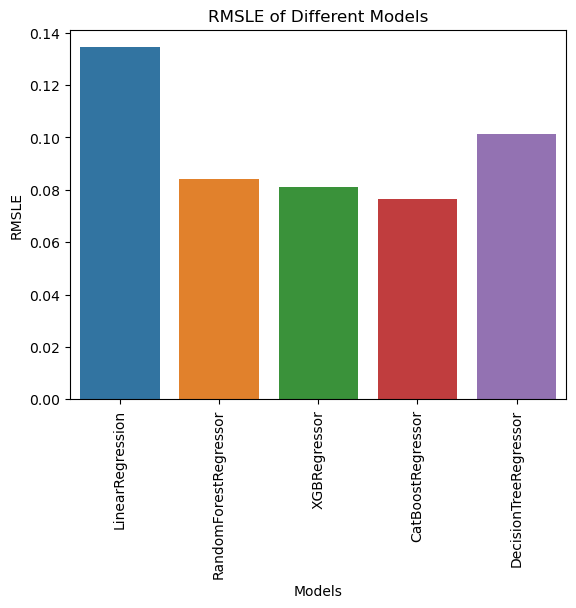

In [177]:
# Create a list of model names
model_names = ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor', 'CatBoostRegressor', 'DecisionTreeRegressor']

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_RF, rmsle_xgb,rmsle_cb, rmsle_dtm]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()


In [178]:
print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  CatBoostRegressor
RMSLE Value:  0.07653758759288866

Worst Model:  LinearRegression
RMSLE Value:  0.13442861840766002


A low RMSLE value indicates that the model is making accurate predictions, so a very low RMSLE is generally considered desirable. However, a model with an RMSLE that is too low could indicate overfitting, where the model has become too specialized to the training data and is not generalizing well to new, unseen data. In these cases, it may be better to have a slightly higher RMSLE, as this would indicate that the model is making more general predictions that are less likely to be affected by small variations in the training data.

# FEATURE IMPORTANCE 

Feature importance is a technique for understanding the relative importance of features in a model. It involves assigning a score to each feature based on its contribution to the overall performance of the model. The scores can then be used to identify which features are the most important for making accurate predictions and which features may be redundant or even detrimental to the model's performance.

In the context of regression models, feature importance can be used to improve the RMLSE (root mean squared logarithmic error) by identifying which features have the most impact on the target variable and optimizing the model accordingly. By focusing on the most important features and eliminating or reducing the impact of less important ones, it is possible to improve the model's accuracy and reduce the RMLSE. Additionally, feature importance can be used to identify which features may be causing overfitting and adjust the model accordingly to improve its generalization performance.

##### Using the get_feature_importance method from the CatBoostRegressor

Here we use the get_feature_importance method from the CatBoostRegressor class to calculate the feature importances for the model trained on the input data. The feature importances are calculated using the "PredictionValuesChange" type, which indicates the contribution of each feature to the predictions made by the model. 

In [179]:
# Convert the pandas DataFrame to a catboost.Pool object
from catboost import CatBoostRegressor, Pool
train_pool = Pool(data=X_train, label=y_train)

# Fit a CatBoostRegressor model to the data
model = CatBoostRegressor(random_state=0)
model.fit(train_pool)

# Calculate the feature importances
feature_importances = model.get_feature_importance(train_pool, type='PredictionValuesChange')

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[::-1]


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 16.5ms	remaining: 16.4s
1:	learn: 124.4515551	total: 33.7ms	remaining: 16.8s
2:	learn: 121.1051420	total: 41.4ms	remaining: 13.8s
3:	learn: 118.0131759	total: 48.7ms	remaining: 12.1s
4:	learn: 115.1225090	total: 52.7ms	remaining: 10.5s
5:	learn: 112.5008885	total: 58.2ms	remaining: 9.65s
6:	learn: 109.7836982	total: 61.9ms	remaining: 8.78s
7:	learn: 107.4033951	total: 63.7ms	remaining: 7.9s
8:	learn: 104.9744962	total: 65.4ms	remaining: 7.21s
9:	learn: 102.8218347	total: 67.3ms	remaining: 6.66s
10:	learn: 100.6806423	total: 69.1ms	remaining: 6.22s
11:	learn: 98.4500980	total: 71ms	remaining: 5.85s
12:	learn: 96.6125667	total: 72.9ms	remaining: 5.53s
13:	learn: 94.6094222	total: 74.8ms	remaining: 5.27s
14:	learn: 92.6806954	total: 76.7ms	remaining: 5.04s
15:	learn: 90.6257312	total: 78.5ms	remaining: 4.83s
16:	learn: 88.9471067	total: 80.3ms	remaining: 4.64s
17:	learn: 87.3550268	total: 82.7ms	remaining: 4.51s
18:	learn: 85.8057

In [180]:
# Print the feature importances
for idx in sorted_idx:
    print("{}: {:.3f}".format(X_train.columns[idx], feature_importances[idx]))


onpromotion_encoded: 41.387
weekday: 24.423
dcoilwtico: 7.274
transactions: 6.934
quarter: 3.409
month: 3.118
pct_change: 3.035
week_lag_1: 1.834
next_day_sales: 1.487
week_ma_7: 1.246
week: 1.245
week_ma_14: 1.189
Promotions_bin_0: 1.083
week_ma_30: 0.886
Promotions_bin_1: 0.833
Holiday_type_Holiday: 0.118
Min: 0.046
city_Guayaquil: 0.040
city_Salinas: 0.035
family_Beverages: 0.035
Store_type_A: 0.027
city_Manta: 0.026
city_Santo_Domingo: 0.025
city_Riobamba: 0.025
city_Babahoyo: 0.024
Store_type_C: 0.021
Promotions_bin_2: 0.020
city_Playas: 0.015
Store_type_D: 0.015
Promotions_bin_3: 0.014
city_El_Carmen: 0.014
city_Ambato: 0.013
city_Cayambe: 0.013
Store_type_E: 0.013
city_Puyo: 0.011
cluster: 0.011
city_Machala: 0.010
city_Latacunga: 0.009
Holiday_type_Workday: 0.008
diff_1: 0.007
city_Quevedo: 0.007
family_Others: 0.005
Store_type_B: 0.005
city_Daule: 0.004
family_Food: 0.002
family_Clothing: 0.002
city_Loja: 0.001
store_nbr: 0.000
city_Libertad: 0.000
city_Ibarra: 0.000
city_Guar

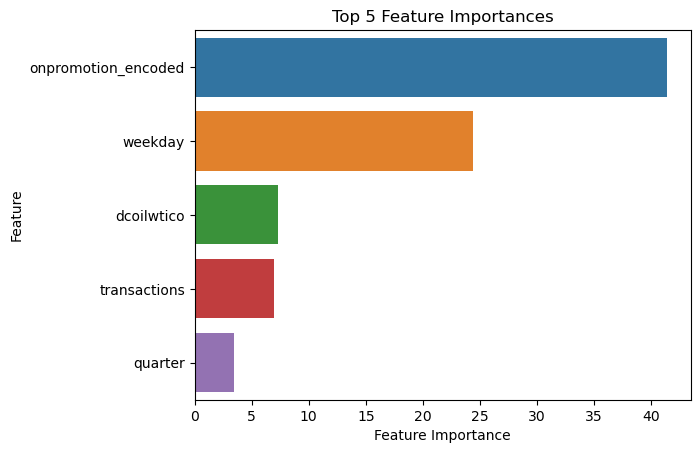

In [181]:
# Plot the feature importances
sns.barplot(x=feature_importances[sorted_idx[:5]], y=X_train.columns[sorted_idx[:5]])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances')

plt.show()

For catboost regressor, the following attributes above contribute the most of improving the prediction and reducing the RMSLE. 

#### Select the top features and train the model

In [182]:
#The next step to improve the performace of CatboostRegressor is to select the top features and train the model on only those features. 

#Here we set a threshold score of 1 and above to be the criteria for selecting the feature. 

#Since we have already implemented the feture importance, we can use this to select the bet features. 


# Fit a CatBoostRegressor model to the data
model = CatBoostRegressor(random_state=0)
model.fit(X_train, y_train)

# Convert the pandas DataFrame to a catboost.Pool object
train_pool = Pool(data=X_train, label=y_train)

# Calculate the feature importances
feature_importances = model.get_feature_importance(train_pool, type='PredictionValuesChange')

# Set a threshold for the minimum importance to keep a feature
importance_threshold = 1

# Keep only the features with importance above the threshold
X_important = X_train.iloc[:, feature_importances > importance_threshold]

# Fit the CatBoostRegressor model to the important features only
model_important = CatBoostRegressor()
model_important.fit(X_important, y_train)

# Make predictions on the reduced feature set
y_pred = model_important.predict(X_important)


Learning rate set to 0.044112
0:	learn: 127.8868726	total: 2.06ms	remaining: 2.06s
1:	learn: 124.4515551	total: 4.01ms	remaining: 2s
2:	learn: 121.1051420	total: 6.39ms	remaining: 2.12s
3:	learn: 118.0131759	total: 8.58ms	remaining: 2.13s
4:	learn: 115.1225090	total: 10.9ms	remaining: 2.16s
5:	learn: 112.5008885	total: 13.6ms	remaining: 2.25s
6:	learn: 109.7836982	total: 16.3ms	remaining: 2.31s
7:	learn: 107.4033951	total: 18.3ms	remaining: 2.27s
8:	learn: 104.9744962	total: 20.3ms	remaining: 2.23s
9:	learn: 102.8218347	total: 22.6ms	remaining: 2.23s
10:	learn: 100.6806423	total: 24.7ms	remaining: 2.22s
11:	learn: 98.4500980	total: 26.4ms	remaining: 2.17s
12:	learn: 96.6125667	total: 28.3ms	remaining: 2.15s
13:	learn: 94.6094222	total: 30.2ms	remaining: 2.13s
14:	learn: 92.6806954	total: 31.9ms	remaining: 2.1s
15:	learn: 90.6257312	total: 33.9ms	remaining: 2.08s
16:	learn: 88.9471067	total: 35.8ms	remaining: 2.07s
17:	learn: 87.3550268	total: 37.7ms	remaining: 2.06s
18:	learn: 85.80573

In [183]:
# Make predictions on the validation set
y_val_pred = model_important.predict(X_validation_test)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_validation_test, y_val_pred)
print("MSE: {:.3f}".format(mse))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("RMSE: {:.3f}".format(rmse))


# Calculate the root mean squared logarithmic error (RMSLE)
rmsle_cb_3 = np.sqrt(np.mean((np.log(y_val_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: {:.3f}".format(rmsle_cb_3))

MSE: 1326.683
RMSE: 36.424
RMSLE: 0.074


#### Permutation importance 

Permutation importance is a method to calculate the importance of individual features in a machine learning model. The idea behind permutation importance is to randomly shuffle the values of a single feature and observe the resulting decrease in the model performance. The decrease in the performance metric indicates the importance of the feature. The more the decrease in the performance, the more important the feature is considered to be.

Permutation importance can be used to improve RandomForestRegressor in the following ways:

Feature selection: By calculating permutation importance, you can identify the most important features for your prediction task. You can then use this information to select the most important features for training your RandomForestRegressor model, which can result in improved performance and reduced training time.

Model improvement: By using permutation importance, you can also identify features that are not contributing much to the model's performance. By removing such features from the training data, you can improve the performance of the RandomForestRegressor model.

In [184]:
from sklearn.inspection import permutation_importance

# Fit the Random Forest Regressor on the training data
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)

# Calculate the permutation importance for each feature
result = permutation_importance(reg, X_validation_test, y_validation_test, n_repeats=10, random_state=0)

# Create a DataFrame to store the feature names and their corresponding permutation importance score
feature_importance = pd.DataFrame({'feature': X_validation_test.columns,
                                   'permutation_importance': result.importances.mean(axis=1)})

# Sort the DataFrame by permutation importance in descending order
feature_importance.sort_values(by='permutation_importance', ascending=False, inplace=True)

# Print the top 5 most important features
print(feature_importance.head(5))


                feature  permutation_importance
7               weekday                1.402408
2          transactions                0.417739
14           pct_change                0.126027
17  onpromotion_encoded                0.009429
26     Promotions_bin_0                0.008143


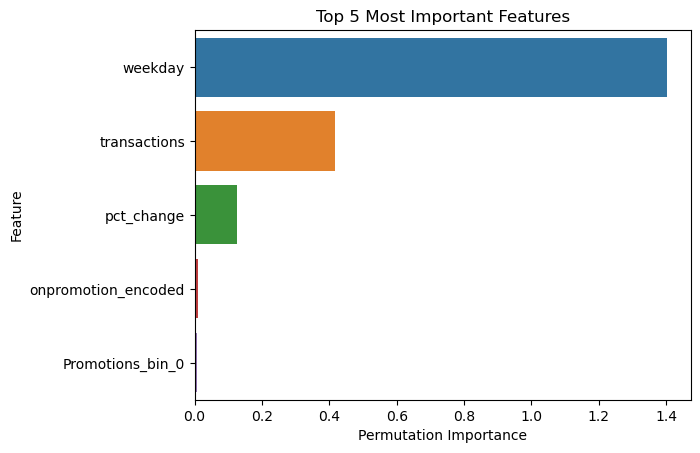

In [185]:
sns.barplot(x='permutation_importance', y='feature', data=feature_importance.head(5))
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Top 5 Most Important Features')
plt.show()

#### Select the top n features to re-train the RandomForestRegressor 

In [186]:
# Select the top n features to re-train the RandomForestRegressor in hopes of improving the model

n = 5 # number of top features
X_important = X_train[feature_importance['feature'].head(n)]

# Train the RandomForestRegressor on the selected features
reg_important = RandomForestRegressor(random_state=0)
reg_important.fit(X_important, y_train)

best_model_RFR = reg_important

# Make predictions on the validation set using the new model
y_pred = reg_important.predict(X_validation_test[feature_importance['feature'].head(n)])

print(y_pred)




[434.09148465 442.05198083 365.61468316 418.34604406 507.09116568
 596.3252251  431.38436774 428.83192342 476.0901787  450.86919647
 429.98876393 629.93497792 702.72198935 481.76963794 423.7190937
 473.98845901 357.14253013 427.86183236 532.06722553 655.29426253
 412.5032559  407.46305036 436.7102546  399.95071453 431.63071893
 656.44101997 647.15617515 425.61769882 423.80513772 441.00731166
 343.88627326 429.61523032 541.38949107 578.71406376 408.67337004
 386.3901896  387.61769222 377.69694057 457.13877108 605.27686847
 703.69237607 496.6201514  499.86858424 517.53048421 388.40644829
 460.70212116 570.96902745 595.38950373 456.45204929 424.95448849
 450.95346724 356.92617447 428.37208232 573.50080055 568.22692099
 454.3221761  422.95559811 442.0662078  386.87175809 464.65581414
 480.83416757 547.7147054  453.29182894 412.95642653 429.61020856
 352.14374294 477.97275024 569.35123472 579.73046574 488.01365949
 444.46704966 474.83443359 435.09252937 430.22223507 562.69457821
 572.917888

In [187]:
# Calculate the RMSLE
rmsle_RF_opt = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: {:.3f}".format(rmsle_RF_opt))

RMSLE: 0.074


### Using shapely Values for the feature importance 

In [188]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


Shapely values are a feature importance measure used in machine learning to evaluate the contribution of each feature towards the model's prediction. They measure the change in the model's prediction when the feature is excluded or permuted randomly. Higher the shapely value, higher is the contribution of the feature towards the model's prediction.

To use shapely values to evaluate the feature importance, you can calculate the prediction values change when a feature is excluded or permuted, and compare it to the prediction values of the original model. You can calculate the shapely values for each feature and rank them in order to determine the most important features in your model.

By using shapely values to evaluate the feature importance, you can get a better understanding of how the features are contributing to the model's prediction, and you can use this information to improve the performance of your RandomForestRegressor. For example, you can remove the features that have a low shapely value or use feature engineering to create new features that have a higher shapely value.

In [189]:
import shap

# Need to load JS vis in the notebook
shap.initjs()

/Users/shubh/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [190]:
from xgboost import XGBRegressor

# instantiate the regressor
xgc = XGBRegressor(random_state=0)

# fit the XGBoost regressor
xgc.fit(X_train, y_train)

# create the explainer
explainer = shap.Explainer(xgc.predict, X_train)

# calculate the SHAP values for the validation test data
shap_values = explainer(X_validation_test)

# get the expected value
expected_value = xgc.predict(X_train).mean()
print('Expected Value:', expected_value)


PermutationExplainer explainer: 86it [00:10,  1.37s/it]                         

Expected Value: 350.4427


The implication of the expected value depends on the specific problem you are trying to solve and the context of your analysis. In general, a high expected value is desirable, as it suggests that the features you have selected for your model are important for making accurate predictions. On the other hand, a low expected value may indicate that you need to reconsider your feature selection strategy, or that you may need to collect additional data to improve the performance of your model.

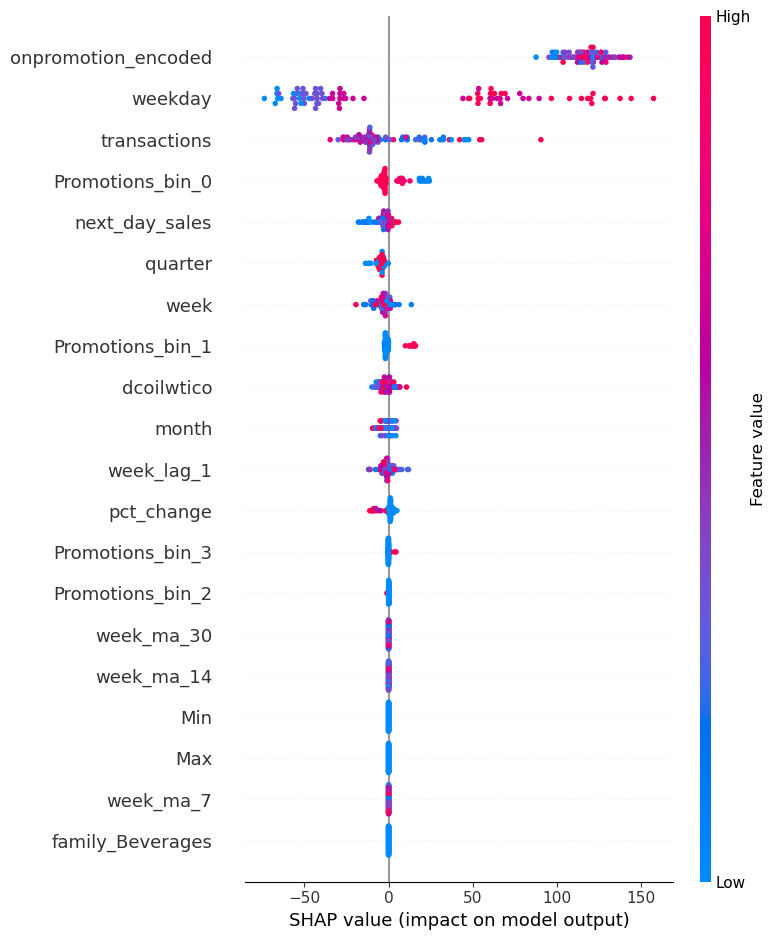

In [191]:
#Global Interpretaion

shap.summary_plot(shap_values, X_validation_test)

##### Select the top n features and retrain the XGBRegressor

In [192]:
# Select the top n features
n = 5 # number of top features
X_important = X_train.iloc[:, np.argsort(np.abs(shap_values.values).mean(0))[-n:]]

xgc_important = XGBRegressor(random_state=0)
xgc_important.fit(X_important, y_train)

y_val_pred = xgc_important.predict(X_validation_test.loc[:, X_important.columns])

# Calculate the root mean squared logarithmic error (RMSLE)
rmsle_XGB_O = np.sqrt(np.mean((np.log(y_val_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: {:.3f}".format(rmsle_XGB_O))


RMSLE: 0.082


#### Using the get_score method from the XGBRegressor

The get_score method from the XGBRegressor returns a dictionary of feature importance scores based on the number of times each feature is split on across all trees in the model. These scores can be used to identify the most important features in the dataset and can provide insights into which features are most strongly associated with the target variable.

In [193]:
# Use XGBRegressor to obtain the feature importance scores

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)

# Get the feature importance scores
importance = xgb.get_booster().get_score(importance_type='weight')

# Convert the feature importance scores to a DataFrame and sort by score in descending order
importance_df = pd.DataFrame(list(importance.items()), columns=['feature', 'score'])
importance_df.sort_values(by='score', ascending=False, inplace=True)

# Select the top n features
n = 5 # specify the number of top features
top_features = importance_df['feature'].head(n)

# Train XGBRegressor on the top n features
xgb_top_features = XGBRegressor(random_state=0)
xgb_top_features.fit(X_train[top_features], y_train)

# Predict using the model trained on top n features
y_pred = xgb_top_features.predict(X_validation_test[top_features])

# Calculate the RMSLE
rmsle_XGB_O2 = np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_validation_test + 1))**2))
print("RMSLE: ", rmsle_XGB_O2)


RMSLE:  0.06920557572214027


###### Comparison for all models 

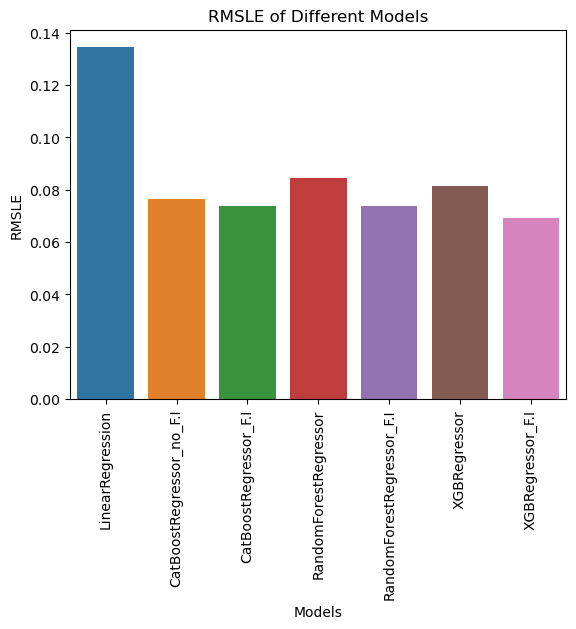

In [194]:
# Create a list of model names
model_names = ['LinearRegression', 'CatBoostRegressor_no_F.I', 'CatBoostRegressor_F.I','RandomForestRegressor','RandomForestRegressor_F.I','XGBRegressor','XGBRegressor_F.I' ]

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_cb, rmsle_cb_3, rmsle_RF, rmsle_RF_opt,rmsle_xgb,rmsle_XGB_O2]


# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [195]:

print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  XGBRegressor_F.I
RMSLE Value:  0.06920557572214027

Worst Model:  LinearRegression
RMSLE Value:  0.13442861840766002


# HYPERPARAMETER TUNING 

Hyperparameter tuning can improve the RMSLE (Root Mean Squared Logarithmic Error) of a regression model by selecting the hyperparameters that result in the best performance on the validation set. By finding the optimal set of hyperparameters, the model can generalize better to new, unseen data, which is reflected in a lower RMSLE. Additionally, hyperparameter tuning can help prevent overfitting, which is a common problem in machine learning.

Since linear regressor did not perform too well, we have decided to use hyperparameter tuning to improve the model. 

##### LinearRegression with hyperparameter tuning 

In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_log_error

# Normalize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_test_scaled = scaler.transform(X_validation_test)

# Initialize the linear regression model
reg = LinearRegression()

# Since there are no hyperparameters to tune in this case, we can directly fit the model
reg.fit(X_train_scaled, y_train)

# Predict on the validation test data
y_pred = reg.predict(X_validation_test_scaled)

# Calculate the RMSLE
rmsle_lg_hyp = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_lg_hyp)



RMSLE:  0.13621548332770095


#### Linear Regression with Top 10 Features using Grid Search and Cross Validation

In [197]:
# Select the top 10 features based on permutation importance
top_10_features = feature_importance.head(10)['feature']
X_train_10 = X_train[top_10_features]
X_validation_test_10 = X_validation_test[top_10_features]

# Normalize the training and validation test data
scaler = StandardScaler()
X_train_10_scaled = scaler.fit_transform(X_train_10)
X_validation_test_10_scaled = scaler.transform(X_validation_test_10)

# Train a Linear Regression model on the top 10 features
lin_reg = LinearRegression()

# Fit the model
lin_reg.fit(X_train_10_scaled, y_train)

# Make predictions on the validation set
y_pred = lin_reg.predict(X_validation_test_10_scaled)

# Calculate the mean squared error on the validation set
mse = mean_squared_error(y_validation_test, y_pred)
print("Mean Squared Error on the validation set: ", mse)

# Calculate the RMSLE
rmsle_lg_top = np.sqrt(mean_squared_log_error(y_validation_test, y_pred))
print("RMSLE: ", rmsle_lg_top)


Mean Squared Error on the validation set:  4679.198718758792
RMSLE:  0.13480499948337782


##### Compare LinearRegressor with hyperparameter tuning and without

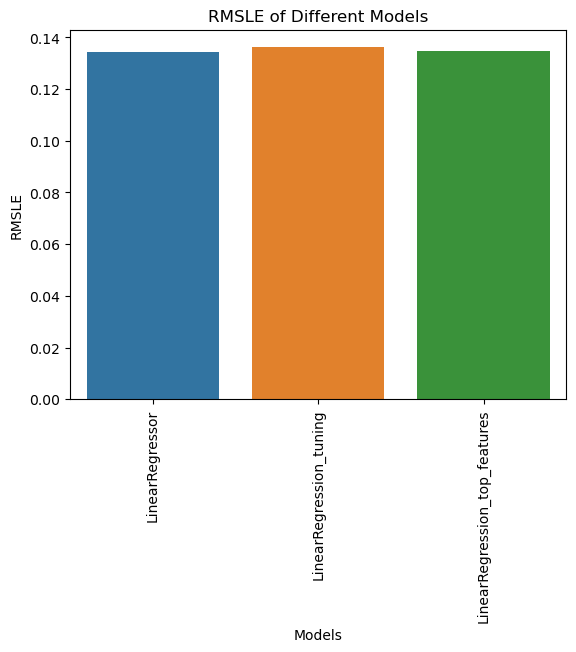

In [198]:
# Create a list of model names
model_names = ['LinearRegressor', 'LinearRegression_tuning', "LinearRegression_top_features" ]

# Create a list of RMSLE values
rmsle_values = [rmsle_lg, rmsle_lg_hyp, rmsle_lg_top]

# Create a dictionary of model names and RMSLE values using the zip function
rmsle_dict = dict(zip(model_names, rmsle_values))

# Find the model with the least RMSLE value using the min function
best_model = min(rmsle_dict, key=rmsle_dict.get)

# Find the model with the biggest RMSLE value using the max function
worst_model = max(rmsle_dict, key=rmsle_dict.get)

sns.barplot(x=list(rmsle_dict.keys()), y=list(rmsle_dict.values()))
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE of Different Models")
plt.xticks(rotation=90)
plt.show()

In [199]:
print("Best Model: ", best_model)
print("RMSLE Value: ", rmsle_dict[best_model])
print("")
print("Worst Model: ", worst_model)
print("RMSLE Value: ", rmsle_dict[worst_model])

Best Model:  LinearRegressor
RMSLE Value:  0.13442861840766002

Worst Model:  LinearRegression_tuning
RMSLE Value:  0.13621548332770095


As can be oberserved there was no significant improvement in the RMSLE metric even with hyperparameter tuning and feature importance. 

### MODELLING WITH STATS MODELS (ARIMAX/SARIMAX)

In [200]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [201]:
Final_data.reset_index(inplace=True)
#Final_data = Final_data.set_index('date')
#Final_data.index.rename('date', inplace=True)

In [202]:
Final_data.head()

,date,store_nbr,sales,cluster,transactions,dcoilwtico,week,quarter,month,weekday,...,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo
0,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2013-01-01,1,0.0,13,770.0,93.14,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [203]:
new_df = Final_data[['date', 'sales']]

In [204]:
new_df = new_df.set_index('date')

In [205]:
new_df.head()

,sales
date,
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0


In [206]:
new_df_sampled = new_df.resample('M').mean()

In [207]:
!pip install pmdarima

In [208]:
import statsmodels.api as sm

import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt

In [209]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
     

In [210]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [211]:
#stasionarity test
new_df_sampled = new_df_sampled.dropna()
#adf_test(new_df_sampled)
#log_deseasonalized_data = np.log(deseasonalized_data)
#deseasonalized_data = deseasonalized_data.dropna()
result = adfuller(new_df_sampled)
test_statistic = result[0]
critical_values = result[4]
if test_statistic < critical_values['5%']:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')

The time series is non-stationary.


In [212]:
#differencing
new_df_sampled2 = new_df_sampled.diff().dropna()

In [213]:
result = adfuller(new_df_sampled2)
test_statistic = result[0]
critical_values = result[4]
if test_statistic < critical_values['5%']:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')

The time series is stationary.


The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


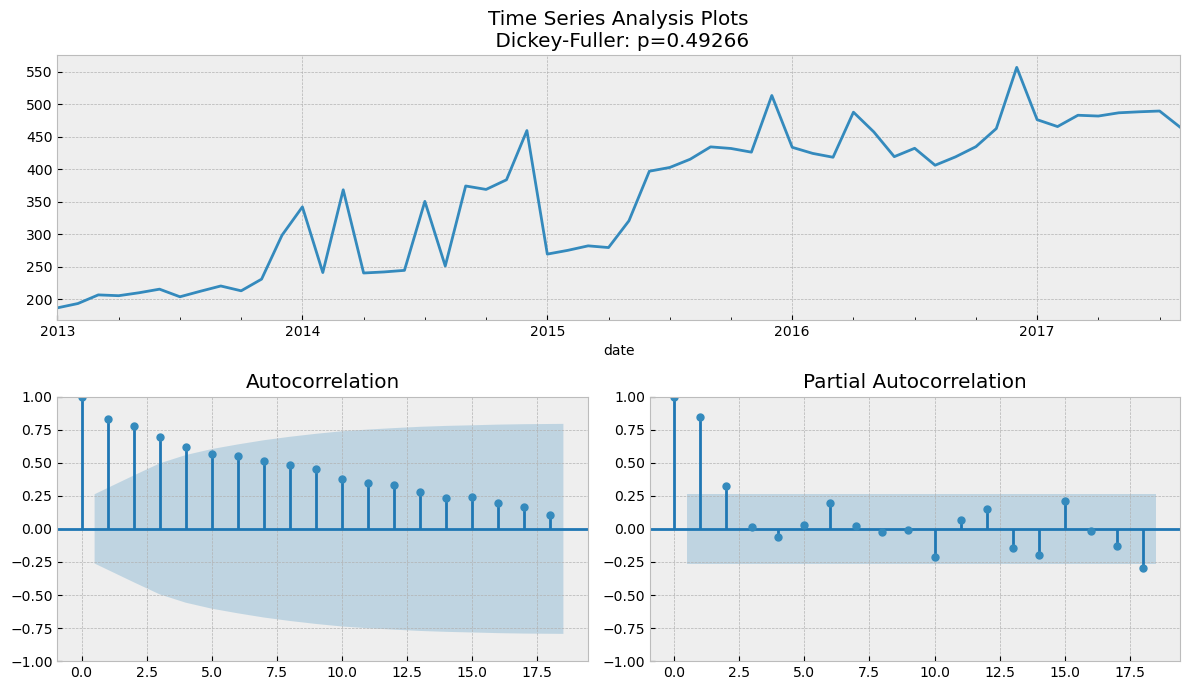

In [214]:
time_series = new_df_sampled.iloc[:, 0]
tsplot(time_series)


In [215]:
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, start_p = 0, start_q = 0, test = "adf", seasonal = False, trace = True)
    
    return autoarima_model

In [216]:
#arima estimator
estimator_model = arimamodel(new_df_sampled)
estimator_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=824.620, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=618.467, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=766.356, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=608.909, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=610.806, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=610.894, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=608.259, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=655.881, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=615.024, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=609.874, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=610.049, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=685.572, Time=0.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -300.071
Date:                Sun, 10 Dec 2023   AIC                            608.142
Time:                        11:58:16   BIC                            616.243
Sample:                    01-31-2013   HQIC                           611.283
                         - 08-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.6943     28.260      0.874      0.382     -30.695      80.083
ar.L1          0.5403      0.101      5.345      0.000       0.342       0.738
ar.L2          0.3887      0.110      3.533      0.000       0.173       0.604
sigma2      2555.3664    448.192      5.701      0.000    1676.926    3433.807
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.61   Prob(JB):                         0.37
Heteroskedasticity (H):               0.57   Skew:                            -0.26
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [217]:
#parameter estimation
arima_model = ARIMA(new_df_sampled, order = (2, 1, 3))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   56
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -291.378
Date:                Sun, 10 Dec 2023   AIC                            594.756
Time:                        11:58:16   BIC                            606.800
Sample:                    01-31-2013   HQIC                           599.413
                         - 08-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6112      0.205      2.978      0.003       0.209       1.013
ar.L2         -0.7297      0.160     -4.551      0.000      -1.044      -0.415
ma.L1         -1.1840      0.681     -1.739      0.0

In [218]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5    
    return rmse

def rmsle(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    log_y_pred = np.log(y_pred + 1)
    log_y_true = np.log(y_true + 1)
    squared_error = (log_y_pred - log_y_true) ** 2
    mean_squared_error = np.mean(squared_error)
    rmsle = mean_squared_error ** 0.5
    return rmsle

#def rmsle(y_pred, y_true):
#    return np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_true + 1))**2))

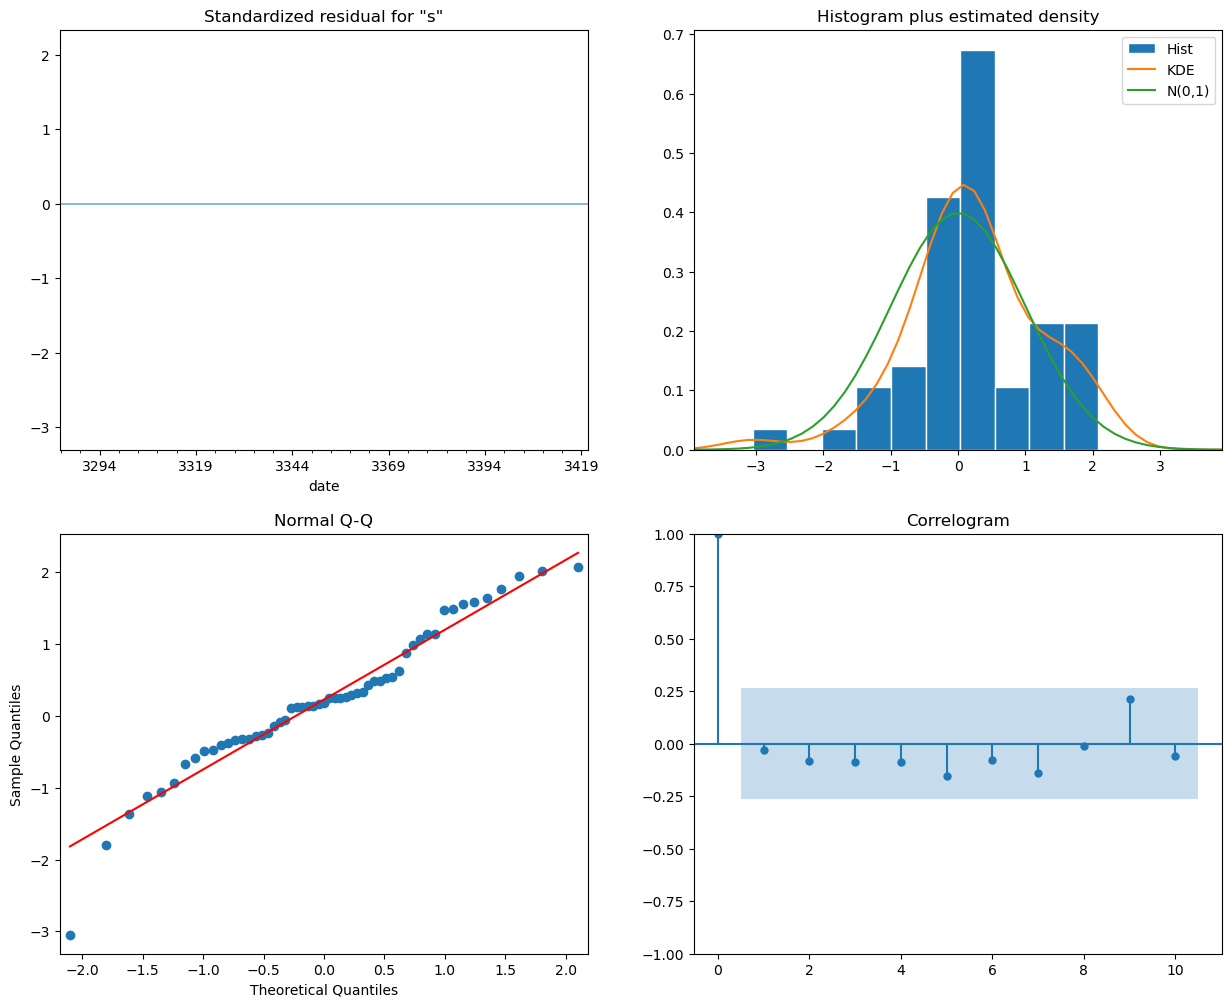

In [219]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

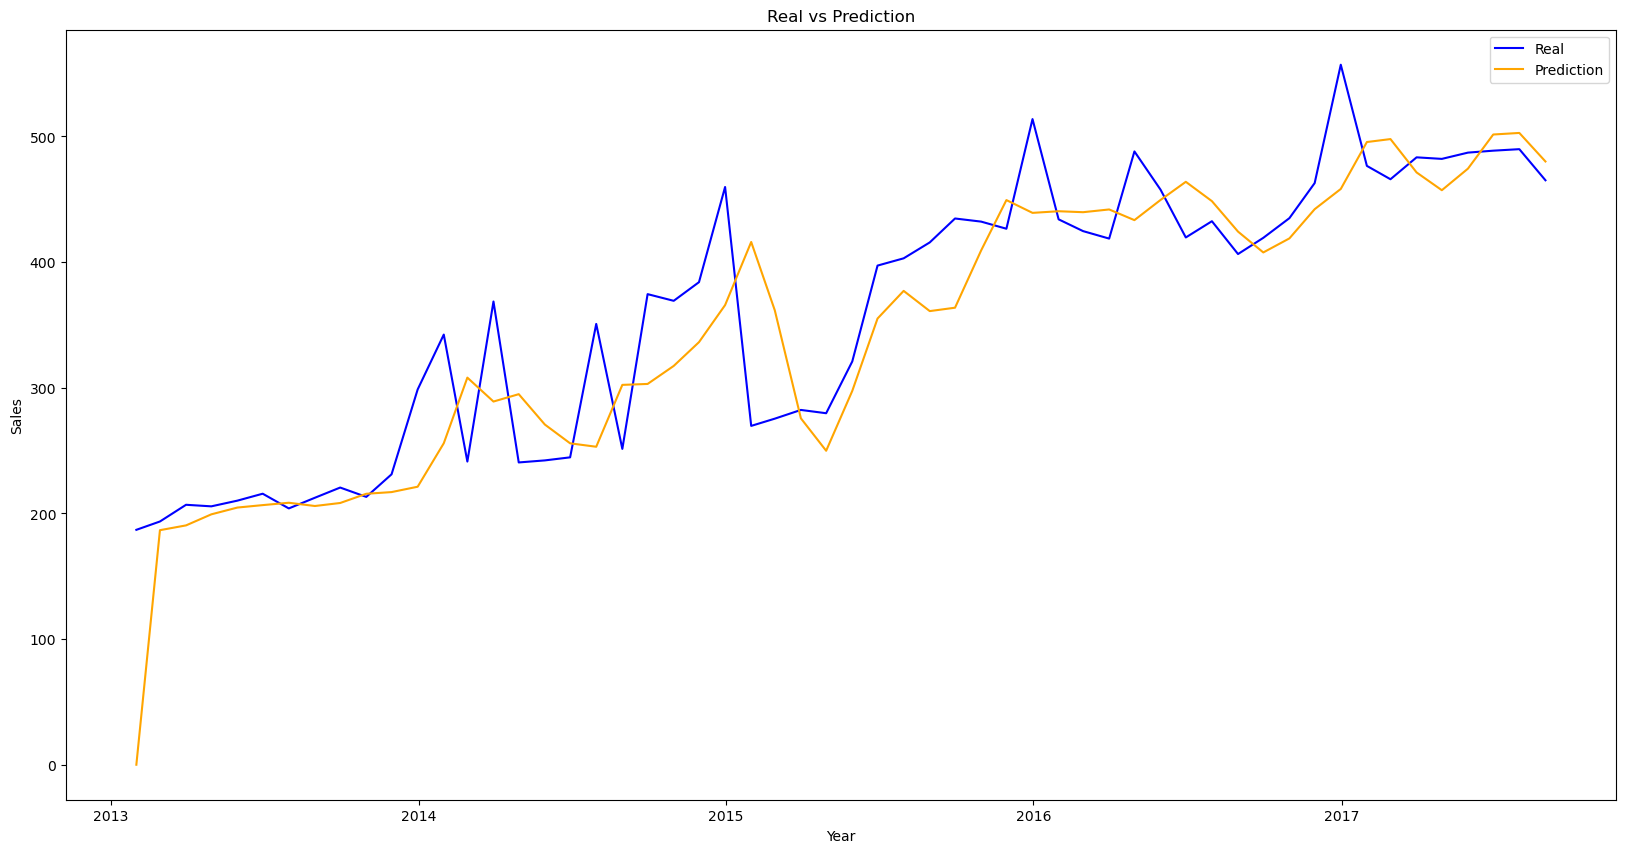

In [220]:
#in sample forecasting
pred = model.predict(dynamic = False)
pred

plt.figure(figsize = (20, 10))

plt.plot(new_df_sampled, color = 'b', label = 'Real')
plt.plot(pred, color = 'orange', label = 'Prediction')

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Real vs Prediction')

plt.legend()

plt.show()

In [221]:
#model accuracy test
model_mape = mape(new_df_sampled, pred)
model_rmse = rmse(new_df_sampled, pred)
model_rmsle = rmsle(new_df_sampled, pred)
print('MAPE: ', model_mape)
print('RMSE: ', model_rmse)
print('RMSLE: ', model_rmsle)

MAPE:  38.78368755245333
RMSE:  53.84952361560502
RMSLE:  0.8992880263174939


In [222]:
new_df_sampled.tail(10)

,sales
date,
2016-11-30,462.916675
2016-12-31,557.114822
2017-01-31,476.596791
2017-02-28,465.971468
2017-03-31,483.400632
2017-04-30,482.172948
2017-05-31,487.162797
2017-06-30,488.707278
2017-07-31,489.909880


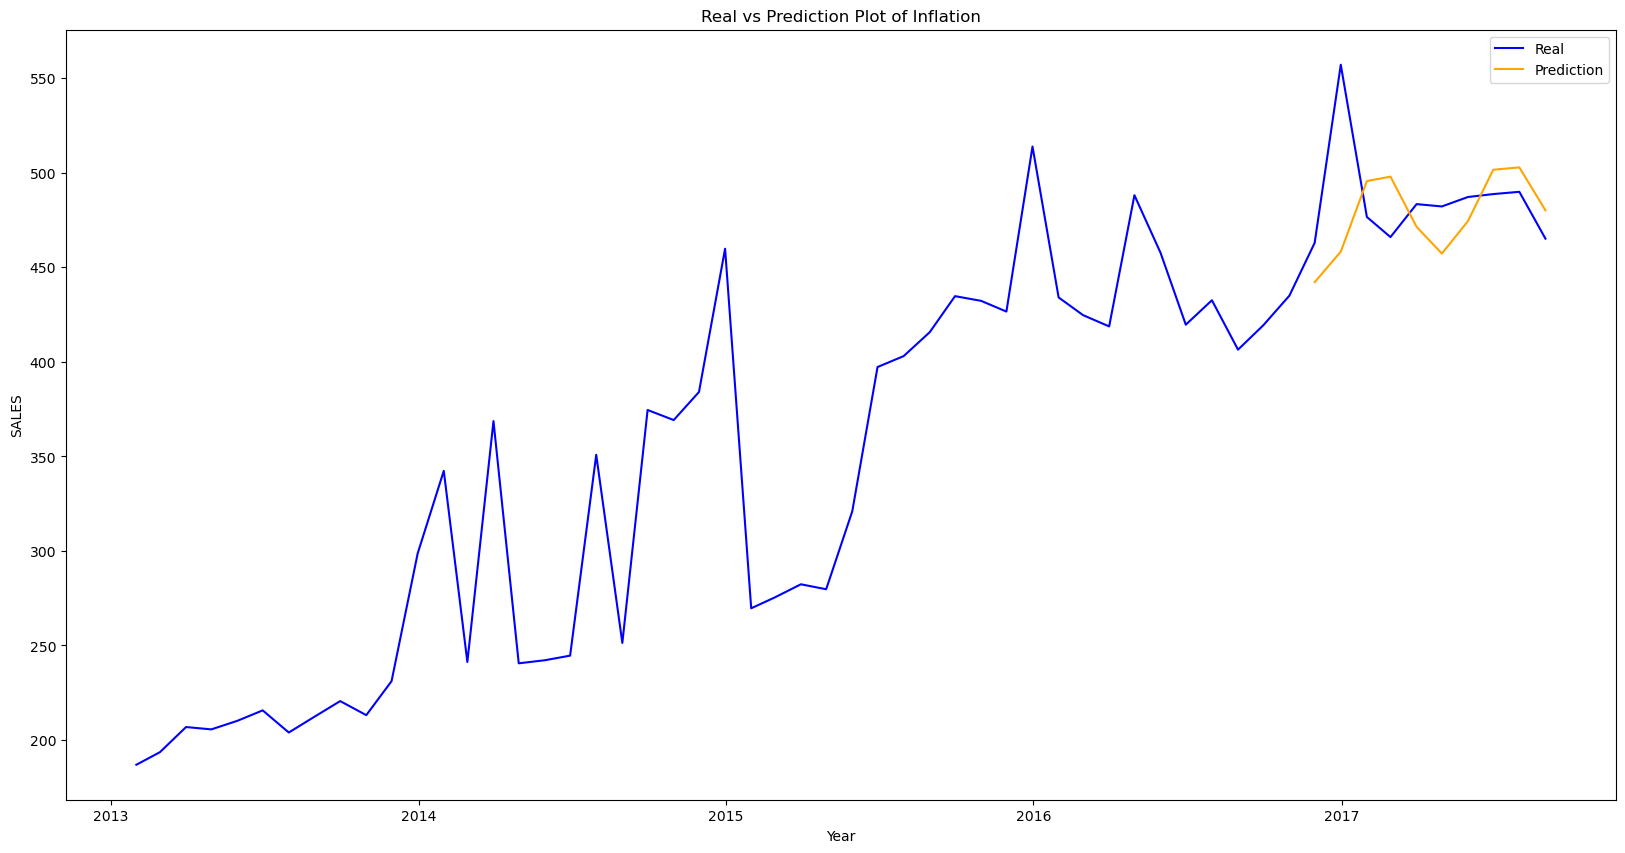

In [223]:
#out of sample forecasting
pred = model.predict(start=pd.to_datetime('2016-11-30'),end=pd.to_datetime('2017-08-31'))

#plot the predicted values
plt.figure(figsize = (20, 10))
plt.plot(new_df_sampled, color = 'b', label = 'Real')
plt.plot(pred, color = 'orange', label = 'Prediction')
plt.xlabel('Year')
plt.ylabel('SALES')
plt.title('Real vs Prediction Plot of Inflation')
plt.legend()
plt.show()


In [224]:
pred.describe()

count     10.000000
mean     478.146345
std       21.204843
min      442.139699
25%      461.528057
50%      477.266962
75%      497.347628
max      502.824360
Name: predicted_mean, dtype: float64

In [225]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model
model = SARIMAX(new_df_sampled, order=(1, 0, 0), seasonal_order=(1, 1, 0, 7))

# Fit the model
results = model.fit()

# Print the results summary
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.96523D+00    |proj g|=  1.47246D-01

At iterate    5    f=  4.94425D+00    |proj g|=  2.31165D-03

At iterate   10    f=  4.93994D+00    |proj g|=  3.18950D-02

At iterate   15    f=  4.93430D+00    |proj g|=  5.91248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   2.481D-06   4.934D+00
  F =   4.9342996991059662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                   56
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood                -276.321
Date:                           Sun, 10 Dec 2023   AIC                            558.642
Time:                                   11:58:17   BIC                            564.317
Sample:                               01-31-2013   HQIC                           560.795
                                    - 08-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6047      0.102      5.931      0.000       0.405       0.805
ar.S.L7       -0.4158      0.145     -2.866      0.004      -0.700      -0.131
sigma2      4469.3914    917.155      4.873      0.000    2671.801    6266.982
===================================================================================
Ljung-Box (L1) (Q):                   4.07   Jarque-Bera (JB):                 1.36
Prob(Q):                              0.04   Prob(JB):                         0.51
Heteroskedasticity (H):               0.25   Skew:                             0.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
model = SARIMAX(new_df_sampled, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), trend='c', 
                enforce_stationarity=True, enforce_invertibility=True)

sarima_results = model.fit(maxiter=100)

Non-invertible starting seasonal moving average Using zeros as starting parameters.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25545D+00    |proj g|=  8.25006D-02

At iterate    5    f=  4.23294D+00    |proj g|=  5.09503D-03

At iterate   10    f=  4.19209D+00    |proj g|=  3.45662D-02

At iterate   15    f=  4.14801D+00    |proj g|=  3.56992D-03

At iterate   20    f=  4.14743D+00    |proj g|=  2.13966D-03

At iterate   25    f=  4.14717D+00    |proj g|=  1.42183D-03

At iterate   30    f=  4.14686D+00    |proj g|=  1.47564D-03

At iterate   35    f=  4.14682D+00    |proj g|=  8.64999D-05

At iterate   40    f=  4.14681D+00    |proj g|=  6.24917D-05

At iterate   45    f=  4.14681D+00    |proj g|=  9.67511D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [227]:
sarima_results.specification

{'seasonal_periods': 12,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (0, 1, 1),
 'seasonal_order': (1, 1, 1, 12),
 'k_diff': 1,
 'k_seasonal_diff': 1,
 'k_ar': 0,
 'k_ma': 1,
 'k_seasonal_ar': 12,
 'k_seasonal_ma': 12,
 'k_ar_params': 0,
 'k_ma_params': 1,
 'trend': 'c',
 'k_trend': 1,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

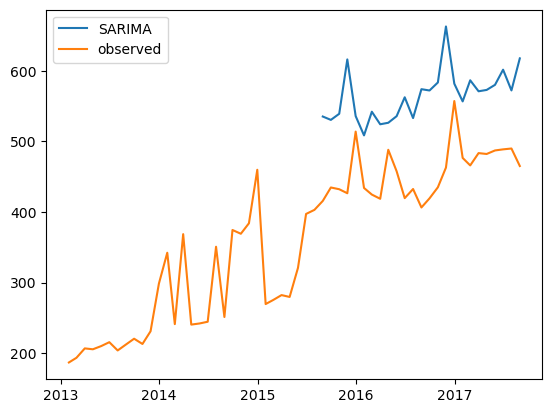

In [228]:
dates = new_df_sampled.index
# Create SARIMA mean forecast
sarima_pred = sarima_results.get_forecast(25)
sarima_mean = sarima_pred.predicted_mean

# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(dates[-25:], sarima_mean, label='SARIMA');
plt.plot(new_df_sampled, label='observed');
plt.legend();



In [229]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

y_true = new_df_sampled.values
y_pred = sarima_mean.values

rmsle_value = rmsle(y_true, y_pred)
print("RMSLE:", rmsle_value)

RMSLE: 0.5968820226090084


# Deployment

In [230]:
import joblib

Save the model to disk

In [231]:
# Save the selected-feature XGBRegressor model to a file using joblib
filename = 'xgb_model_selected_features.joblib'
joblib.dump(xgb_top_features, filename)

['xgb_model_selected_features.joblib']

In [232]:
# Check if the model is an XGBRegressor or not
if isinstance(xgb_top_features, XGBRegressor):
    # Save the XGBRegressor model to a file using joblib
    filename = 'xgb_model_selected_features.joblib'
    joblib.dump(xgb_top_features, filename)
    print("XGBRegressor model saved successfully.")
else:
    print("Error: Invalid model type.")


XGBRegressor model saved successfully.


Making Predictions on Test Data using a Saved XGBRegressor Model

In [233]:
# Load the saved XGBoost model from file
loaded_model = joblib.load('xgb_model_selected_features.joblib')

# Load the test data from file
test_data = Final_test_data_

# Select the same top 5 features as used to train the model

n = 5 # number of top features

X_test_important = test_data[importance_df['feature'].head(n)]

# Make predictions on the test data using the loaded model
predictions = loaded_model.predict(X_test_important)

# Display the predictions
print(predictions)


[517.89325 444.73303 486.77228 522.08136 587.31744 543.5283  503.57675
 484.1473  440.08105 468.7722  503.57675 542.5034  584.66284 523.1725
 491.24628 442.83093]
